## cosine similarity among fragmented replays

In [392]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [497]:
import os
import cupy as cp
import numpy as np
import datajoint as dj
import spyglass as nd
import pandas as pd
import matplotlib.pyplot as plt
import json
import multiprocessing

# ignore datajoint+jupyter async warnings
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)

from spyglass.common import (Session, IntervalList,LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode,LFPBand,interval_list_intersect)
from spyglass.common import TaskEpoch
import spyglass.spikesorting as ss

from spyglass.spikesorting.v0 import (SortGroup, 
                                    SortInterval,
                                    SpikeSortingPreprocessingParameters,
                                    SpikeSortingRecording, 
                                    SpikeSorterParameters,
                                    SpikeSortingRecordingSelection,
                                    ArtifactDetectionParameters, ArtifactDetectionSelection,
                                    ArtifactRemovedIntervalList, ArtifactDetection,
                                      SpikeSortingSelection, SpikeSorting,
                                   CuratedSpikeSortingSelection,CuratedSpikeSorting,Curation)

from spyglass.spikesorting.v0.spikesorting_curation import MetricParameters,MetricSelection,QualityMetrics
from spyglass.spikesorting.v0.spikesorting_curation import WaveformParameters,WaveformSelection,Waveforms
from spyglass.common.common_position import IntervalPositionInfo, IntervalPositionInfoSelection,IntervalLinearizedPosition

from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename
from pprint import pprint
from spyglass.shijiegu.helpers import interval_union
from spyglass.shijiegu.load import load_run_sessions
from spyglass.shijiegu.Analysis_SGU import RippleTimesWithDecode,EpochPos,TrialChoice
from spyglass.shijiegu.fragmented import find_spike_count_ratio

In [405]:
from spyglass.shijiegu.singleUnit import session_unit, find_spikes
from spyglass.shijiegu.placefield import place_field,placefield_to_peak1dloc
from spyglass.shijiegu.curation_manual import get_session_duration

### Specify date, session, and electrode

In [395]:
nwb_copy_file_name = "lewis20240110_.nwb"

In [396]:
run_session_ids, run_session_names, pos_session_names = load_run_sessions(nwb_copy_file_name)

*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
lewis20240110_ 1         01_Rev2Sleep1  pos 0 valid ti
lewis20240110_ 2         02_Rev2Session pos 1 valid ti
lewis20240110_ 3         03_Rev2Sleep2  pos 2 valid ti
lewis20240110_ 4         04_Rev2Session pos 3 valid ti
lewis20240110_ 5         05_Rev2Sleep3  pos 4 valid ti
lewis20240110_ 6         06_Rev2Session pos 5 valid ti
lewis20240110_ 7         07_Rev2Sleep4  pos 6 valid ti
lewis20240110_ 8         08_Rev2Session pos 7 valid ti
lewis20240110_ 9         09_Rev2Sleep5  pos 8 valid ti
lewis20240110_ 10        10_Rev2Session pos 9 valid ti
lewis20240110_ 11        11_Rev2Sleep6  pos 10 valid t
 (Total: 11)



In [398]:
epoch_num = 0
session_name = run_session_names[epoch_num]
pos_name = pos_session_names[epoch_num]

### 1. get firing rate vector for each fragmented interval.

In [534]:
time_bins, binned_spike_counts, average_firing_rate, ratio, ratio_dict, firing_rate_F, firing_rate_C, unit_name = get_binned_spikes(
                                                    nwb_copy_file_name, session_name,  fragmented = True, count = False)

time_bins_cont, binned_spike_counts_cont, average_firing_rate_cont = get_binned_spikes(
                                                      nwb_copy_file_name, session_name, fragmented = False, count = False)

In [406]:
# get peak firing rate in the place field
average_firing_rates_peakrun = []
average_firing_rates_run = []
session_duration = get_session_duration(nwb_copy_file_name,session_name) # in seconds

for unit in unit_name:
    (e, u) = unit
    placefield, peak_fr, xbins, ybins, mobility_spike_count, all_spike_count = place_field(
            nwb_copy_file_name, session_name, pos_name, e, u)
    
    average_firing_rates_peakrun.append(peak_fr)
    average_firing_rates_run.append(mobility_spike_count/session_duration)

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 3036


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 3490


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1091


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 899


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1517


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 548


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 349


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 558


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 208


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 453


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 2524


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1066


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 3197


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 622


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1583


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 2101


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 821


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1629


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1933


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 256


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 133


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 15


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1119


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 4570


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 625


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1234


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 2650


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 3779


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 241


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 556


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 732


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 2055


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1980


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 119


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 531


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 389


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1319


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 602


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 409


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 684


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 564


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1293


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 811


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 381


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 472


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 8295


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 126


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1134


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 4068


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 233


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1254


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 706


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 529


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1012


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 2557


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 3192


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 143


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1117


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 710


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 437


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1435


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 5010


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 8322


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 145


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 984


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 314


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 2120


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 178


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1050


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1285


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 306


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 274


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 137


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 485


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 781


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 134


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 309


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 2712


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 534


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 7241


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1537


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 2311


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 970


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1001


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 796


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 93


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1514


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 733


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 419


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 971


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 167


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1407


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 462


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 3403


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 455


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 4106


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 2665


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1707


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 30


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 501


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 668


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 41


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 7380


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 65


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 272


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1560


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1171


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1434


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 2675


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1005


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 480


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 326


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 591


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1019


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 585


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 761


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 491


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1319


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1147


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 6456


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1107


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1130


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 735


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 291


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 109


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 379


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 660


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 483


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 5728


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 142


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 773


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 4365


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 192


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 568


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 533


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 3717


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 856


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 633


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 779


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 151


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 981


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 116


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 651


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 528


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 619


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1673


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 807


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1824


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 2678


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1015


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1918


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 469


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 627


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1920


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1566


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 404


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 47


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 2226


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 163


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 116


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 541


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 428


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 4094


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 3596


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1409


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 533


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 105


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1181


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 366


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 458


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 580


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1514


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 384


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 463


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 2373


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1194


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 599


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 3488


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 6824


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 194


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 142


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 552


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 88


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 792


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 747


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 949


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 735


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1957


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 573


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 363


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 511


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 720


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 954


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1585


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1023


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 258


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 472


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 318


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1293


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1166


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 320


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1646


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 247


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 606


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1297


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 251


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1642


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 888


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 118


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 254


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 163


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1815


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1508


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1278


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1031


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 57


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 3114


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 442


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1891


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 652


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 2042


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 2921


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1662


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1062


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1556


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 295


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 638


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 303


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 2409


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 6965


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1259


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1082


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1124


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 778


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 613


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 5439


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 829


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1088


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 3324


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 5394


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 934


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 2454


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 812


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 824


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 5908


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1277


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 439


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 148


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 2143


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 602


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 96


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 242


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1311


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1380


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1070


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 3094


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 3112


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 2379


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 291


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1509


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 637


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 1139


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 577


In [407]:
average_firing_rates = np.hstack([a.reshape((-1,1)) for a in average_firing_rate])
average_firing_rates_cont = np.hstack([a.reshape((-1,1)) for a in average_firing_rate_cont])

In [408]:
average_firing_rates.shape

(263, 84)

In [409]:
average_firing_rates_cont.shape

(263, 362)

In [410]:
len(average_firing_rates_peakrun)

263

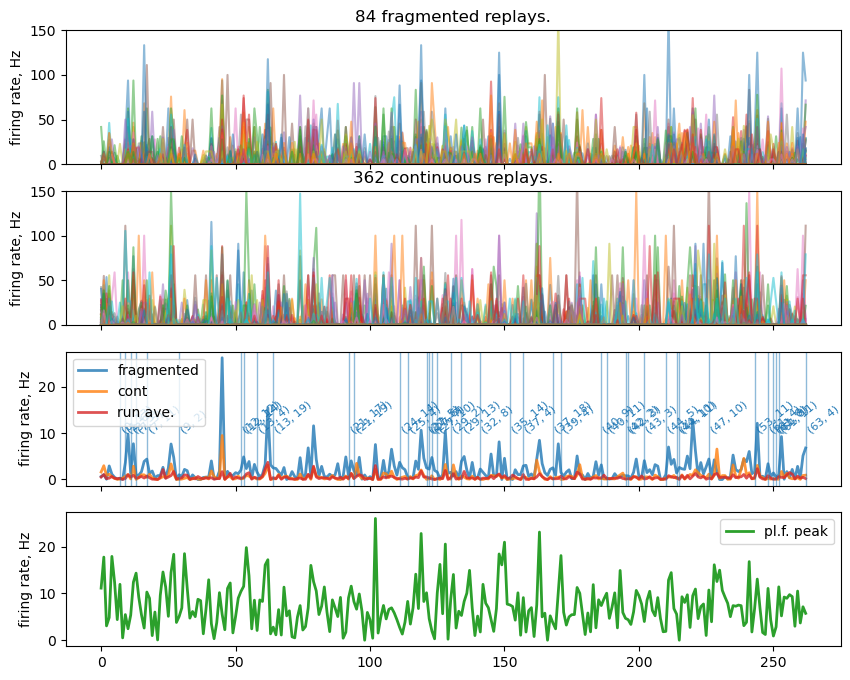

In [417]:
fig,axes = plt.subplots(4,1,figsize = (10,8),sharex = True)

x_raw = np.mean(average_firing_rates, axis = 1)
y_raw = np.mean(average_firing_rates_cont, axis = 1)

axes[0].plot(average_firing_rates, alpha = 0.5);
axes[0].set_title(str(np.shape(average_firing_rates)[1]) + " fragmented replays.")
axes[0].set_ylabel("firing rate, Hz")
axes[0].set_ylim([0,150])

axes[1].plot(average_firing_rates_cont, alpha = 0.5);
axes[1].set_title(str(np.shape(average_firing_rates_cont)[1]) + " continuous replays.")
axes[1].set_ylabel("firing rate, Hz")
axes[1].set_ylim([0,150])

axes[2].plot(x_raw, color = 'C0', linewidth = 2, label = "fragmented", alpha = 0.8);
axes[2].plot(y_raw, color = 'C1', linewidth = 2, label = "cont", alpha = 0.8);
axes[2].plot(average_firing_rates_run, color = 'C3', linewidth = 2, label = "run ave.", alpha = 0.8);
axes[2].set_ylabel("firing rate, Hz")
axes[2].legend()

axes[3].plot(average_firing_rates_peakrun, color = 'C2', linewidth = 2, label = "pl.f. peak");
axes[3].set_ylabel("firing rate, Hz")
axes[3].legend()


# annotate fragmented cells
ind = np.argwhere(np.array(ratio) >= 3).ravel()
cell_list = [unit_name[_] for _ in ind]
for cell_ind in range(len(cell_list)):
    if x_raw[ind[cell_ind]] == 0 or y_raw[ind[cell_ind]] == 0:
        continue
    axes[2].axvline(ind[cell_ind],color = 'C0',linewidth = 1, alpha = 0.5)
    axes[2].text(ind[cell_ind], 10, str(cell_list[cell_ind]), color = 'C0', rotation = 40, fontsize = 8)

In [418]:
import statsmodels.api as sm

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     93.33
Date:                Mon, 28 Apr 2025   Prob (F-statistic):           9.96e-19
Time:                        10:12:29   Log-Likelihood:                -330.27
No. Observations:                 230   AIC:                             664.5
Df Residuals:                     228   BIC:                             671.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1543      0.070    -16.393      0.0

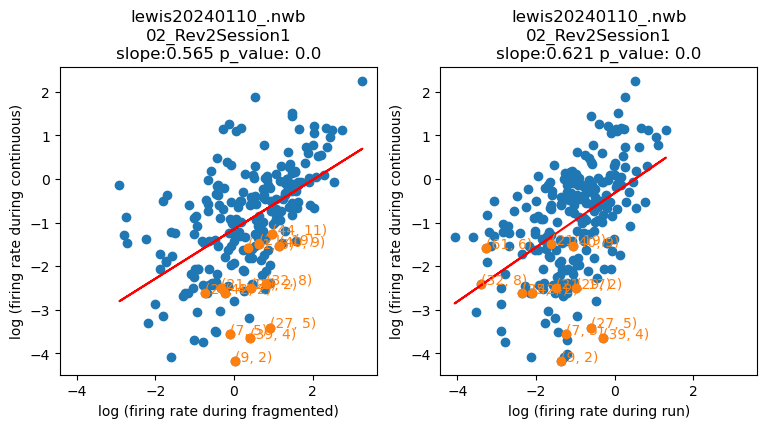

In [435]:
THRESHOLD = 5 #FRAG/CONT firing count ratio
fig,axes = plt.subplots(1,2,figsize = (9,4),sharex = True)

x_raw = np.log(np.mean(average_firing_rates, axis = 1))
y_raw = np.log(np.mean(average_firing_rates_cont, axis = 1))

remove_ind = np.logical_and(~np.isinf(x_raw),~np.isinf(y_raw))
x = x_raw[remove_ind]
y = y_raw[remove_ind]

x_ = sm.add_constant(x)
results = sm.OLS(y, x_).fit()
print(results.summary())
#df = pd.read_html(results.summary().tables[1].as_html(),header=0,index_col=0)[0]

axes[0].plot(x_[:, 1], results.predict(x_), color='red', label='Regression Line')

axes[0].scatter(x, y)
axes[0].plot()
axes[0].set_xlabel("log (firing rate during fragmented)")
axes[0].set_ylabel("log (firing rate during continuous)")
axes[0].set_title(nwb_copy_file_name + "\n" + session_name + "\n" + "slope:"+str(
    np.round(results.params[1], 3))+" p_value: "+str(np.round(results.pvalues[1],3)))

# annotate fragmented cells
ind = np.argwhere(np.array(ratio) >= THRESHOLD).ravel()
cell_list = [unit_name[_] for _ in ind]
x_raw_frag = [x_raw[_] for _ in ind]
y_raw_frag = [y_raw[_] for _ in ind]

for cell_ind in range(len(cell_list)):
    axes[0].scatter(x_raw_frag[cell_ind], y_raw_frag[cell_ind], color = 'C1')
    axes[0].text(x_raw_frag[cell_ind], y_raw_frag[cell_ind], str(cell_list[cell_ind]), color = 'C1')



x_raw = np.log(average_firing_rates_run)
y_raw = np.log(np.mean(average_firing_rates_cont, axis = 1))

remove_ind = np.logical_and(~np.isinf(x_raw),~np.isinf(y_raw))
x = x_raw[remove_ind]
y = y_raw[remove_ind]

x_ = sm.add_constant(x)
results = sm.OLS(y, x_).fit()
print(results.summary())
#df = pd.read_html(results.summary().tables[1].as_html(),header=0,index_col=0)[0]

axes[1].plot(x_[:, 1], results.predict(x_), color='red', label='Regression Line')
axes[1].scatter(x, y)
axes[1].plot()
axes[1].set_xlabel("log (firing rate during run)")
axes[1].set_ylabel("log (firing rate during continuous)")
axes[1].set_title(nwb_copy_file_name + "\n" + session_name + "\n" + "slope:"+str(
    np.round(results.params[1], 3))+" p_value: "+str(np.round(results.pvalues[1],3)))

# annotate fragmented cells
ind = np.argwhere(np.array(ratio) >= THRESHOLD).ravel()
cell_list = [unit_name[_] for _ in ind]
x_raw_frag = [x_raw[_] for _ in ind]
y_raw_frag = [y_raw[_] for _ in ind]
for cell_ind in range(len(cell_list)):
    axes[1].scatter(x_raw_frag[cell_ind], y_raw_frag[cell_ind], color = 'C1')
    axes[1].text(x_raw_frag[cell_ind], y_raw_frag[cell_ind], str(cell_list[cell_ind]), color = 'C1')


In [151]:
data = np.mean(average_firing_rates, axis = 1) * np.mean(average_firing_rates_cont, axis = 1)

order_ind = np.argsort(data)[::-1]
cell_list = [unit_name[ind] for ind in order_ind]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 9117


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 6526


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 6998


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 7586


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 7638


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 3292


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 4563


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 8434


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 5438


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/spikeinterface/core/base.py:1038: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.98.2 is recommended
  warnings.warn(


spike num: 3975


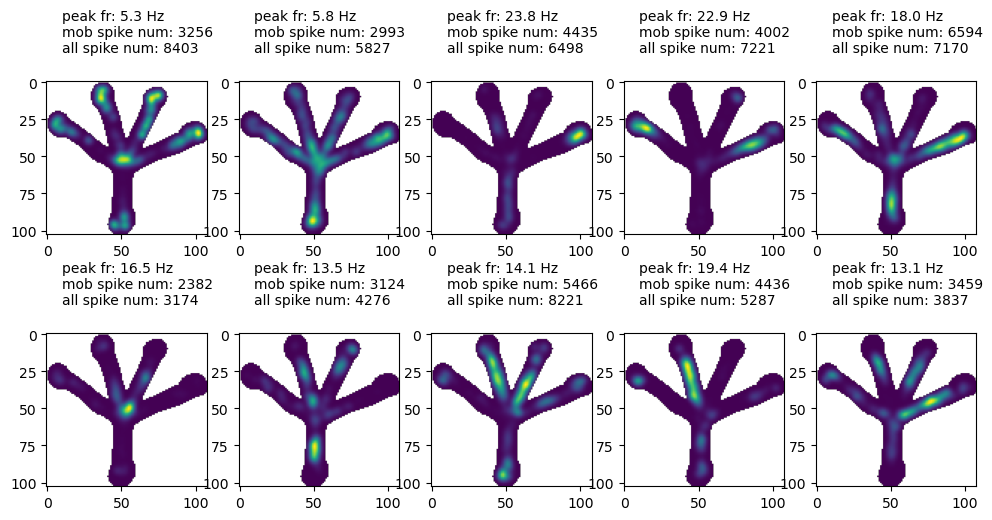

In [152]:
f,axes = plt.subplots(2,5,figsize = (12,6))
axes_flat = axes.flatten()

for unit_ind in range(10):
    (e,u) = cell_list[unit_ind]

    placefield1, peak_fr, xbins, ybins, mobility_spike_count, all_spike_count = place_field(
                nwb_copy_file_name, session_name, pos_name, e, u)
    
    axes_flat[unit_ind].imshow(placefield1)
    axes_flat[unit_ind].text(10,-20,"peak fr: "+str(round(peak_fr,1))+" Hz \n" + 
                                    "mob spike num: "+str(mobility_spike_count) + "\n" +
                                    "all spike num: "+str(all_spike_count))

### 2. Take cosine

In [35]:
from sklearn.metrics.pairwise import cosine_similarity

In [454]:
average_firing_rates.shape

(263, 84)

In [473]:
average_firing_rates = np.hstack([a.reshape((-1,1)) for a in average_firing_rate])
average_firing_rates_cont = np.hstack([a.reshape((-1,1)) for a in average_firing_rate_cont])

average_firing_rates = (average_firing_rates - np.mean(average_firing_rates, axis = 1,keepdims = 1)) #/ (np.std(average_firing_rates, axis = 1, keepdims = 1) + 0.001)
average_firing_rates_cont = (average_firing_rates_cont - np.mean(average_firing_rates_cont, axis = 1,keepdims = 1)
                            ) #/ (np.std(average_firing_rates_cont, axis = 1,keepdims = 1) + 0.001)

In [474]:
C = cosine_similarity(average_firing_rates.T, average_firing_rates.T) # args are (n_samples_X, n_features), 
                        # n_samples = number of fragmented, 
                        # n_features = number of neurons.
C_cont = cosine_similarity(average_firing_rates_cont.T, average_firing_rates_cont.T) # args are (n_samples_X, n_features), 
                        # n_samples = number of fragmented, 
                        # n_features = number of neurons.

In [484]:
C_frag_cont = cosine_similarity(average_firing_rates.T, average_firing_rates_cont.T) # args are (n_samples_X, n_features), 
                        # n_samples = number of fragmented, 
                        # n_features = number of neurons.

In [475]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

/tmp/ipykernel_984481/1612595745.py:8: UserWarning: Adding colorbar to a different Figure <Figure size 1800x600 with 4 Axes> than <Figure size 1000x600 with 4 Axes> which fig.colorbar is called on.
  fig.colorbar(im0, cax=cax, orientation='vertical')
/tmp/ipykernel_984481/1612595745.py:16: UserWarning: Adding colorbar to a different Figure <Figure size 1800x600 with 5 Axes> than <Figure size 1000x600 with 4 Axes> which fig.colorbar is called on.
  fig.colorbar(im1, cax=cax, orientation='vertical')
/tmp/ipykernel_984481/1612595745.py:24: UserWarning: Adding colorbar to a different Figure <Figure size 1800x600 with 6 Axes> than <Figure size 1000x600 with 4 Axes> which fig.colorbar is called on.
  fig.colorbar(im2, cax=cax, orientation='vertical')


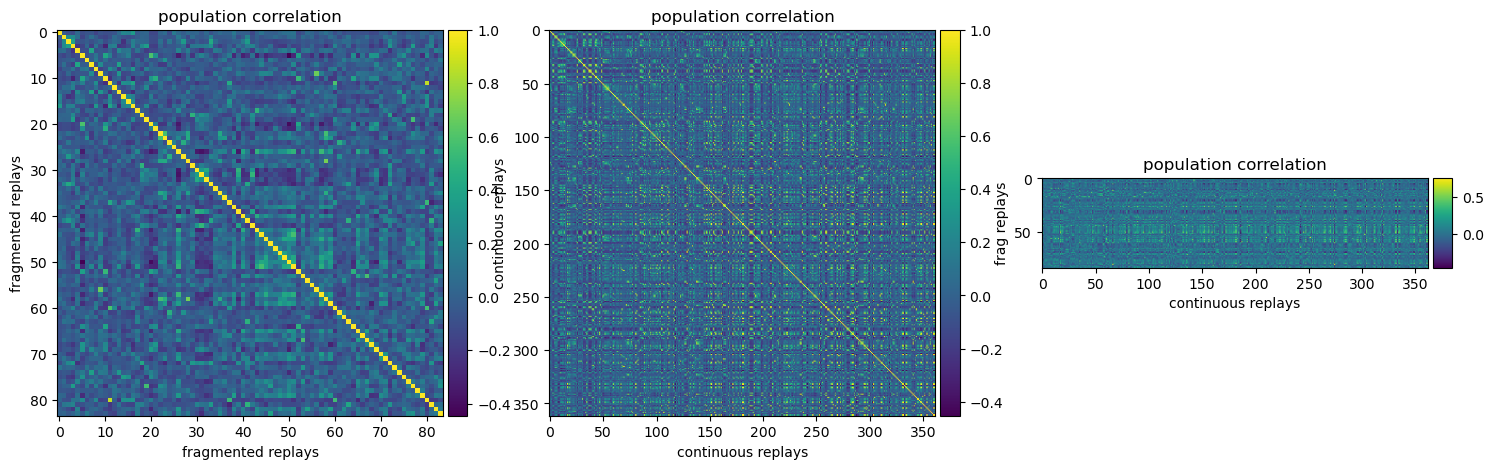

In [486]:
f,axes = plt.subplots(1,3,figsize = (18,6))
im0 = axes[0].imshow(C)
axes[0].set_xlabel("fragmented replays")
axes[0].set_ylabel("fragmented replays")
axes[0].set_title("population correlation")
divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im0, cax=cax, orientation='vertical')

im1 = axes[1].imshow(C_cont)
axes[1].set_xlabel("continuous replays")
axes[1].set_ylabel("continuous replays")
axes[1].set_title("population correlation")
divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

im2 = axes[2].imshow(C_frag_cont)
axes[2].set_xlabel("continuous replays")
axes[2].set_ylabel("frag replays")
axes[2].set_title("population correlation")
divider = make_axes_locatable(axes[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')


In [477]:
def set_lower_triangle_to_nan(arr):
  """Sets the lower triangle of a NumPy array to NaN.

  Args:
    arr: A NumPy array.

  Returns:
    A NumPy array with the lower triangle set to NaN.
  """
  n = arr.shape[0]
  mask = np.triu(np.ones((n, n), dtype=bool), k=1)
  arr_masked = np.where(mask, arr, np.nan)
  return arr_masked

In [478]:
C_upper = set_lower_triangle_to_nan(C)
C_upper[np.isnan(C_upper)] = 0
large_value_ind = np.argsort(C_upper.flatten(order='F'))[::-1]
large_value_subx, large_value_suby = np.unravel_index(large_value_ind[:20], np.shape(C),order='F')

In [479]:
large_value_subx

array([11, 28,  9,  5, 11, 53, 22, 44, 22, 19, 60, 26, 37, 10, 31, 17, 26,
       26, 30, 18])

In [480]:
lis = [(large_value_subx[i], large_value_suby[i]) for i in range(len(large_value_subx))]

In [481]:
def union_find(lis):
    lis = map(set, lis)
    unions = []
    for item in lis:
        temp = []
        for s in unions:
            if not s.isdisjoint(item):
                item = s.union(item)
            else:
                temp.append(s)
        temp.append(item)
        unions = temp
    return unions

In [482]:
sets = union_find(lis)
length_of_sets = [len(s) for s in sets]
sets = [sets[i] for i in np.argsort(length_of_sets)[::-1]]
print(sets)

[{17, 51, 57, 26, 43, 44}, {22, 23, 58, 28}, {80, 37, 11, 60}, {30, 39}, {18, 29}, {10, 52}, {42, 31}, {19, 77}, {67, 53}, {20, 5}, {56, 9}]


Text(0.5, 0, 'cells')

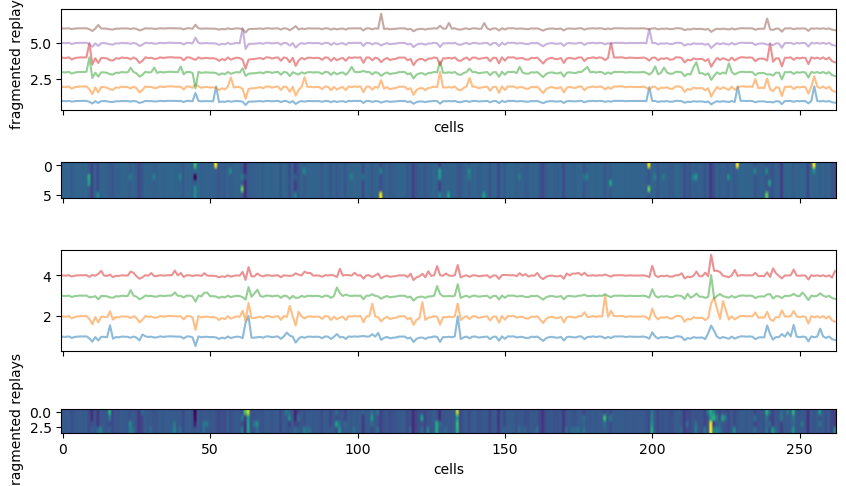

In [483]:
fig,axes = plt.subplots(4,1,figsize = (10,6),sharex = True)
replay_ind = list(sets[0])

Y = []
row_ind = 0
for r_ind in replay_ind:
    row_ind = row_ind + 1
    y = average_firing_rates[:,r_ind]
    Y.append(y)
    axes[0].plot(y/np.max(y) + row_ind, alpha = 0.5);
axes[0].set_ylabel("fragmented replays")
axes[0].set_xlabel("cells")
axes[1].imshow(np.array(Y), aspect = 2)

replay_ind = list(sets[1])

Y = []
row_ind = 0
for r_ind in replay_ind:
    row_ind = row_ind + 1
    y = average_firing_rates[:,r_ind]
    Y.append(y)
    axes[2].plot(y/np.max(y) + row_ind, alpha = 0.5);
axes[3].imshow(np.array(Y), aspect = 2)
axes[3].set_ylabel("fragmented replays")
axes[3].set_xlabel("cells")


In [506]:
StateScript = pd.DataFrame(
        (TrialChoice & {'nwb_file_name':nwb_copy_file_name,
                        'epoch_name':session_name}).fetch1('choice_reward'))

In [507]:
replay_ind = list(sets[0])

In [508]:
intvls, ripple_times, row_inds = get_bins_ripple(nwb_copy_file_name, session_name, bin_width = 0.002, fragmented = True, trial_info = True)

In [509]:
ripple_subset = ripple_times.loc[np.array(row_inds)[replay_ind]]
ripple_subset

event_number    start_time animal_location trial_number  \
84             85  1.704912e+09            home           20   
175           176  1.704912e+09           well2           49   
195           196  1.704913e+09            home           59   
102           103  1.704912e+09           well4           25   
163           164  1.704912e+09            home           45   
165           166  1.704912e+09            home           46   

                                            cont_intvl  \
84   [[1704911634.1275682, 1704911634.2695682], [17...   
175  [[1704912352.963058, 1704912353.009058], [1704...   
195  [[1704912573.3829017, 1704912573.4809017], [17...   
102  [[1704911764.7654755, 1704911764.8574755], [17...   
163  [[1704912243.8691354, 1704912243.9851353], [17...   
165  [[1704912270.2371168, 1704912270.3351166], [17...   

                                            frag_intvl  \
84   [[1704911634.271568, 1704911634.293568], [1704...   
175  [[1704912353.011058, 1704912353.083058], [1704...   
195  [[1704912573.4829016, 1704912573.5989015], [17...   
102  [[1704911764.8594754, 1704911764.9054754], [17...   
163  [[1704912243.9871354, 1704912244.0431354], [17...   
165         [[1704912270.3371167, 1704912270.3931167]]   

           cont_intvl_replay      end_time  duration  mean_zscore  \
84   [[0], [2], [0], [], []]  1.704912e+09  0.614001     3.672870   
175        [[], [], [], [2]]  1.704912e+09  0.425001     2.923572   
195                [[4], []]  1.704913e+09  0.477001     1.075703   
102          [[4], [1], [4]]  1.704912e+09  0.410000     1.500041   
163       [[0], [], [4], []]  1.704912e+09  0.562001          NaN   
165                 [[], []]  1.704912e+09  0.257000     0.286411   

     median_zscore  max_zscore  min_zscore  max_speed  min_speed  \
84        1.177008   17.840514   -1.911289   0.637416   0.029731   
175       0.649195   20.408289   -1.240497   1.414776   0.441543   
195       0.584486    8.574568   -1.638927   1.244022   1.243996   
102       0.391219   13.092980   -1.312129   3.460178   1.039853   
163            NaN         NaN         NaN   1.365916   0.329949   
165      -0.065903    3.438682   -1.182381   0.685095   0.107808   

     median_speed  mean_speed  
84       0.174119    0.214187  
175      0.918044    0.927480  
195      1.244014    1.244014  
102      1.552628    1.990469  
163      0.858030    0.854387  
165      0.367178    0.371863

In [510]:
StateScript.loc[np.array(ripple_subset.trial_number)]

timestamp_H  Home   timestamp_O  OuterWellIndex  rewardNum  current  \
20  1.704912e+09   1.0  1.704912e+09             2.0        1.0      2.0   
49  1.704912e+09   1.0  1.704912e+09             2.0        2.0      2.0   
59  1.704913e+09   1.0  1.704913e+09             4.0        1.0      4.0   
25  1.704912e+09   1.0  1.704912e+09             4.0        2.0      4.0   
45  1.704912e+09   1.0  1.704912e+09             3.0        2.0      3.0   
46  1.704912e+09   1.0  1.704912e+09             2.0        1.0      2.0   

    future_H  future_O  past  past_reward  
20       2.0       1.0   3.0          3.0  
49       2.0       3.0   4.0          1.0  
59       4.0       2.0   3.0          1.0  
25       4.0       3.0   2.0          2.0  
45       3.0       2.0   4.0          4.0  
46       2.0       1.0   3.0          3.0

### in the cell direction

In [320]:
C = cosine_similarity(average_firing_rates, average_firing_rates) # args are (n_samples_X, n_features), 
                        # n_samples = number of fragmented, 
                        # n_features = number of neurons.
C_cont = cosine_similarity(average_firing_rates_cont, average_firing_rates_cont) # args are (n_samples_X, n_features), 
                        # n_samples = number of fragmented, 
                        # n_features = number of neurons.

In [334]:
C_upper = set_lower_triangle_to_nan(C)
C_upper[np.isnan(C_upper)] = 0
large_value_ind = np.argsort(C_upper.flatten(order='F'))[::-1]
large_value_subx, large_value_suby = np.unravel_index(large_value_ind[:10], np.shape(C),order='F')

In [335]:
large_value_subx

array([ 66,  62,   3,  87, 108,  52,  24,   0,  44,  34])

In [336]:
large_value_suby

array([ 94, 207, 250, 207, 207,  53, 162, 162,  53,  53])

Text(0, 0.5, 'cells')

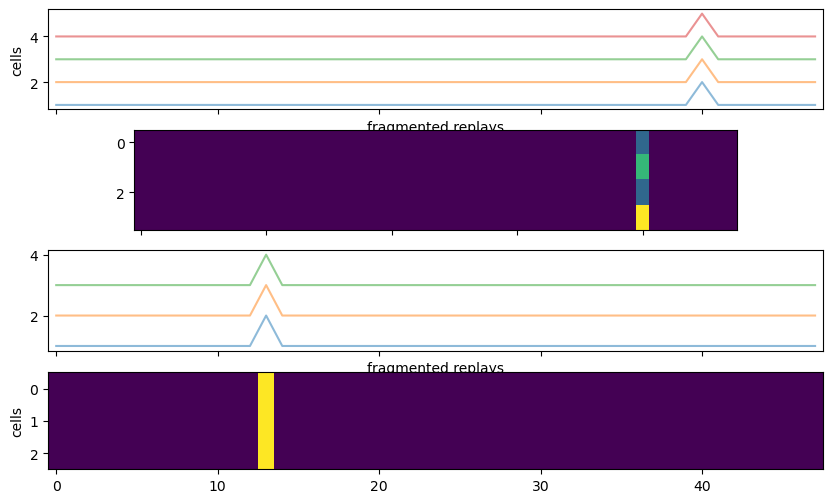

In [337]:
fig,axes = plt.subplots(4,1,figsize = (10,6),sharex = True)
cell_ind = [207, 62, 87, 108]

Y = []
row_ind = 0
for cell in cell_ind:
    row_ind = row_ind + 1
    y = average_firing_rates[cell,:]
    Y.append(y)
    axes[0].plot(y/np.max(y) + row_ind, alpha = 0.5);
axes[0].set_ylabel("cells")
axes[0].set_xlabel("fragmented replays")
axes[1].imshow(np.array(Y), aspect = 2)


cell_ind = [24, 162, 0]

Y = []
row_ind = 0
for cell in cell_ind:
    row_ind = row_ind + 1
    y = average_firing_rates[cell,:]
    Y.append(y)
    axes[2].plot(y/np.max(y) + row_ind, alpha = 0.5);
axes[2].set_xlabel("fragmented replays")

axes[3].imshow(np.array(Y), aspect = 2)
axes[3].set_ylabel("cells")

In [119]:
bin_width = 0.004
binned_spike_counts, cell_list, nwb_units_all, ripple_times, time_axis = get_binned_spikes(nwb_copy_file_name, session_name,
                                                                                bin_width = bin_width, fragmented = True)

print(binned_spike_counts.shape)

KeyboardInterrupt: 

In [275]:
#len(time_axis)

In [276]:
cell_list_ = []  
placefields = {}
placefields_im = {}
mobility_spike_counts = {}
all_spike_counts = {}
peak_frs = {}
count_ratios = {}

for row_ind in range(len(cell_list)):
    print(row_ind)
    e = cell_list[row_ind][0]
    u = cell_list[row_ind][1]
    
    
    nwb_units = electrode_unit(nwb_copy_file_name,session_name,e,curation_id=1)
    print(e,u)
    
    placefield_im, _, _1, _2, _3, _4 = place_field(
        nwb_copy_file_name, session_name, pos_name, e, u,
        curation_id = 1, nwb_units = nwb_units,
        immobility = True,
        normalize = False)
    
    placefield, peak_fr, xbins, ybins, mobility_spike_count, all_spike_count = place_field(
        nwb_copy_file_name, session_name, pos_name, e, u,
        curation_id = 1, nwb_units = nwb_units,
        immobility = False,
        normalize = True)
    if mobility_spike_count < 5:
        continue
    if all_spike_count > 20000:
        continue
        
    cell_list_.append((e,u))
    count_ratios[(e,u)] = count_ratio[row_ind]
    
    placefields[(e,u)] = placefield
    placefields_im[(e,u)] = placefield_im
    peak_frs[(e,u)] = peak_fr
    mobility_spike_counts[(e,u)] = mobility_spike_count
    all_spike_counts[(e,u)] = all_spike_count

#cell_list = cell_list_

0
0 2
spike num: 2688
spike num: 2688
1
0 6
spike num: 1298
spike num: 1298
2
0 7
spike num: 176
spike num: 176
3
0 8
spike num: 1408
spike num: 1408
4
0 9
spike num: 188
spike num: 188
5
0 10
spike num: 1730
spike num: 1730
6
0 12
spike num: 884
spike num: 884
7
3 2
spike num: 45367
spike num: 45367
8
3 3
spike num: 47868
spike num: 47868
9
7 1
spike num: 26415
spike num: 26415
10
7 5
spike num: 171
spike num: 171
11
7 6
spike num: 747
spike num: 747
12
7 9
spike num: 1148
spike num: 1148
13
7 11
spike num: 627
spike num: 627
14
7 12
spike num: 52
spike num: 52
15
7 13
spike num: 84
spike num: 84
16
7 15
spike num: 40077
spike num: 40077
17
7 16
spike num: 301
spike num: 301
18
7 17
spike num: 554
spike num: 554
19
8 4
spike num: 203
spike num: 203
20
8 5
spike num: 3663
spike num: 3663
21
8 7
spike num: 871
spike num: 871
22
8 8
spike num: 593
spike num: 593
23
8 9
spike num: 286
spike num: 286
24
8 10
spike num: 1917
spike num: 1917
25
8 11
spike num: 1210
spike num: 1210
26
8 16
sp

IndexError: index 228 is out of bounds for axis 0 with size 228

In [ ]:
# get rid of interneurons

In [277]:
cell_list_pyr = [c in placefields.keys() for c in cell_list]

In [278]:
cell_pyr = list(placefields.keys())

In [279]:
ic_vectors, pc_vectors, eigenvalues, lambda_min, lambda_max, ic_assembly_activities = compute_assembly_vectors(binned_spike_counts[cell_list_pyr,:])

Session 08_Rev2Session4, num assemblies: 6


### 1b. run GPFA

In [190]:
from elephant.gpfa import GPFA

In [192]:
import quantities as pq

In [193]:
# specify fitting parameters
bin_size = 2 * pq.ms
latent_dimensionality = 4

gpfa_2dim = GPFA(bin_size=bin_size, x_dim=latent_dimensionality)

In [195]:
gpfa_2dim.fit(binned_spike_counts)

ValueError: 

### 2. get cell spiking tendency

In [280]:
_, count_ratio_dict, _1, _2, _3 = find_spike_count_ratio(nwb_units_all,ripple_times)
count_ratio = np.array([count_ratio_dict[u] for u in cell_pyr])

In [281]:
count_argsort_ind = np.argsort(count_ratio)

In [282]:
#cell_list = [cell_list[a] for a in count_argsort_ind]

### 3. inspect rasters

In [283]:
fragmented_ind = count_argsort_ind[count_ratio[count_argsort_ind]>=2]

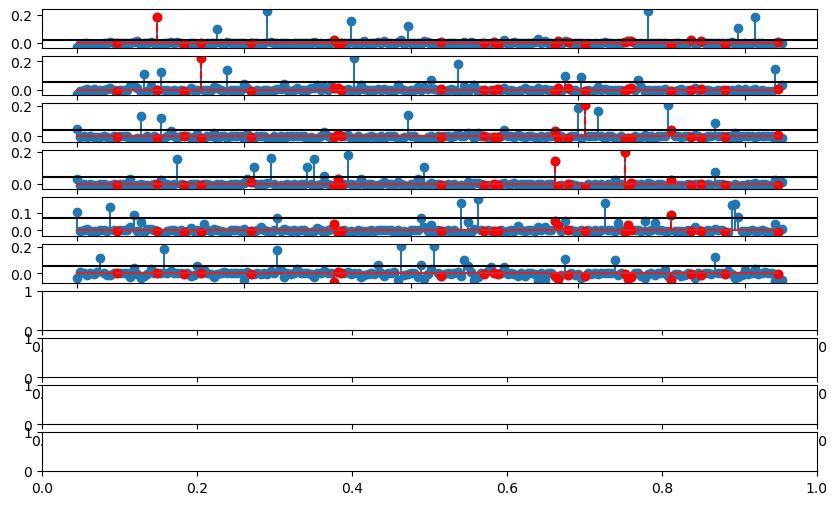

In [284]:
fig, ax = plt.subplots(10,1,figsize = (10,6))

ind = 0
for ic_vector_ind in range(len(ic_vectors))[:10]:
    ic_vector = ic_vectors[ic_vector_ind]
    offset = ind*2
    ax[ind].stem(count_argsort_ind, ic_vector[count_argsort_ind],label = "assembly "+str(ind))
    ax[ind].stem(fragmented_ind,ic_vector[fragmented_ind],linefmt='r--')
    ax[ind].axhline(np.quantile(ic_vector,0.95), color = 'k')
    
    ind += 1
#ax.legend()

In [271]:
ic_vector = ic_vectors[5]
ic_cell_ind = np.argsort(ic_vector)[::-1]
plt.imshow(binned_spike_counts[ic_cell_ind,:])

IndexError: index 5 is out of bounds for axis 0 with size 3

In [ ]:
binned_spike_counts.shape

In [ ]:
binned_spike_counts

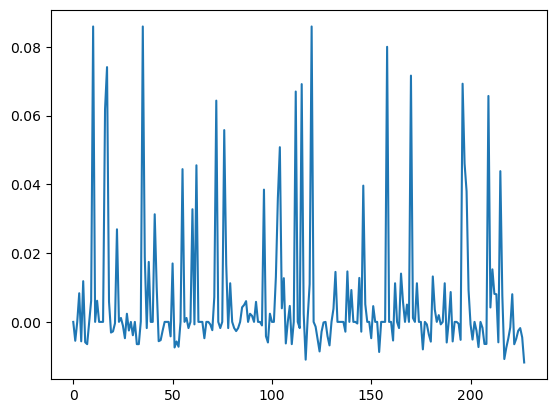

In [272]:
plt.plot(ic_vector)

### 4. assembly activities

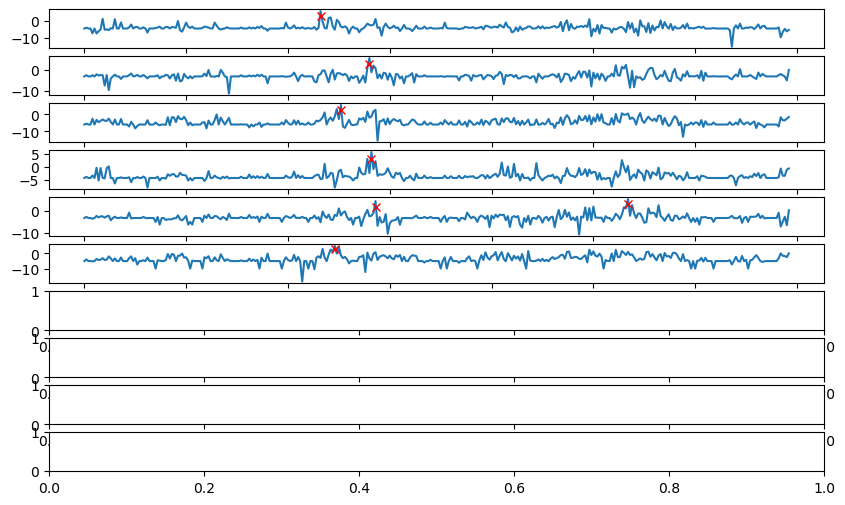

In [285]:
from scipy.signal import find_peaks

min_height = 1.5 # standard deviations - minimum height of event peak
min_dist = 0.040 # s - minimum distance between event peaks

fig, ax = plt.subplots(10,1,figsize = (10,6))

ind = 0
assembly_events_idx_all = []
assembly_peak_heights_all = []
assembly_id_all = []

for ic_vector_ind in range(len(ic_vectors))[:10]:
    ic_assembly_zscore = zscore(ic_assembly_activities[ic_vector_ind])
    assembly_events_idx, assembly_peak_properties = find_peaks(ic_assembly_zscore,
                                                               height=min_height, distance=min_dist/bin_width)
    assembly_events_idx_all.append(assembly_events_idx)
    assembly_peak_heights_all.append(assembly_peak_properties["peak_heights"])
    assembly_id_all.append(ic_vector_ind)
    
    ax[ind].plot(np.log(ic_assembly_activities[ic_vector_ind]),label = "assembly "+str(ind))
    ax[ind].plot(assembly_events_idx,np.log(assembly_peak_properties["peak_heights"]),'rx')
    # find peak
    
    ind += 1
#ax.legend()

In [ ]:
# load position

### 5. place fields

#### by assembly

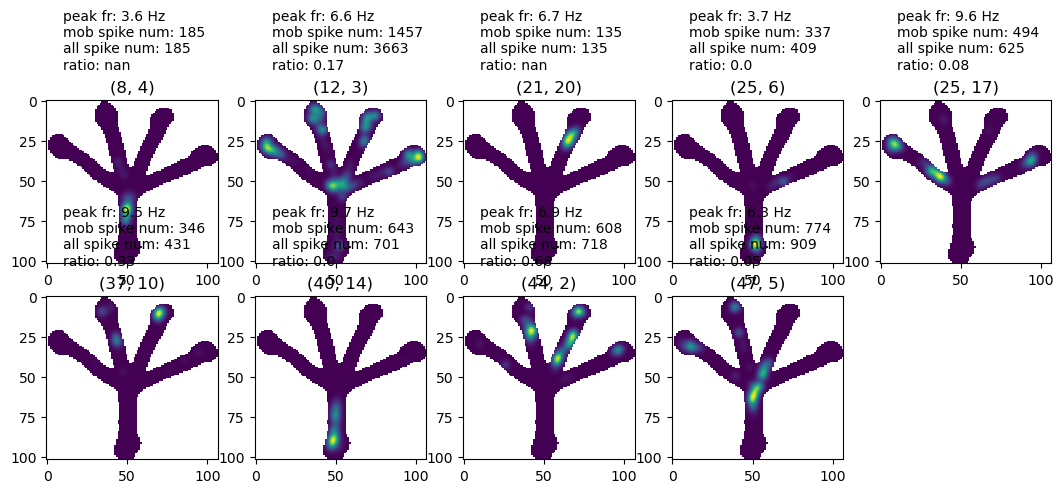

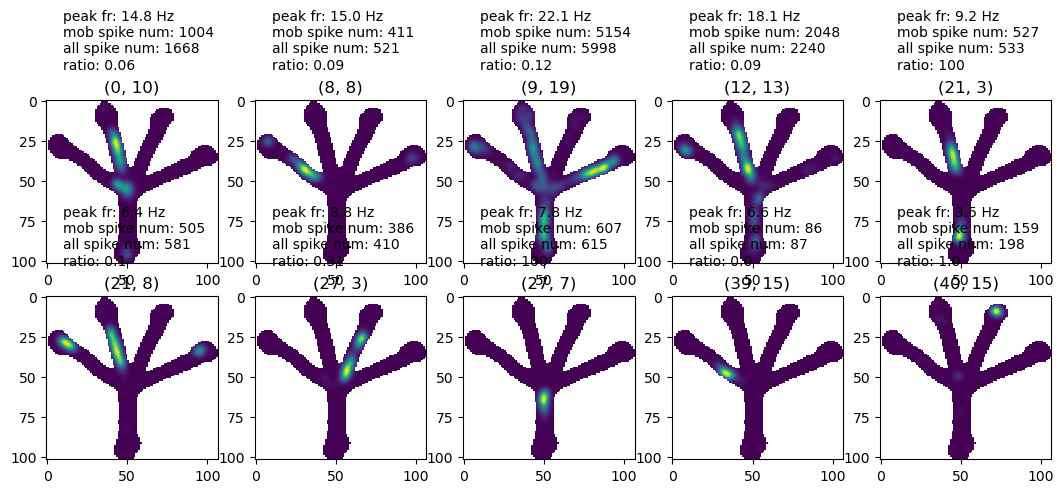

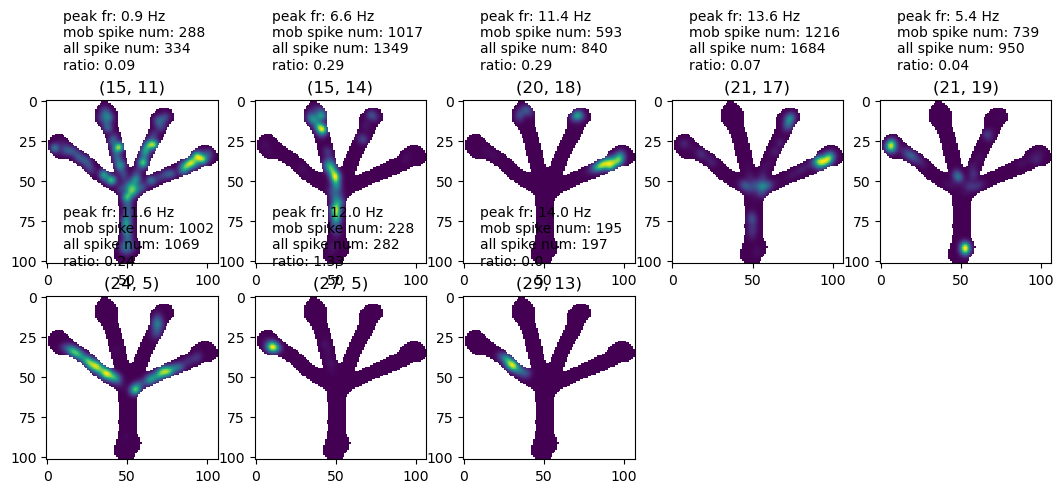

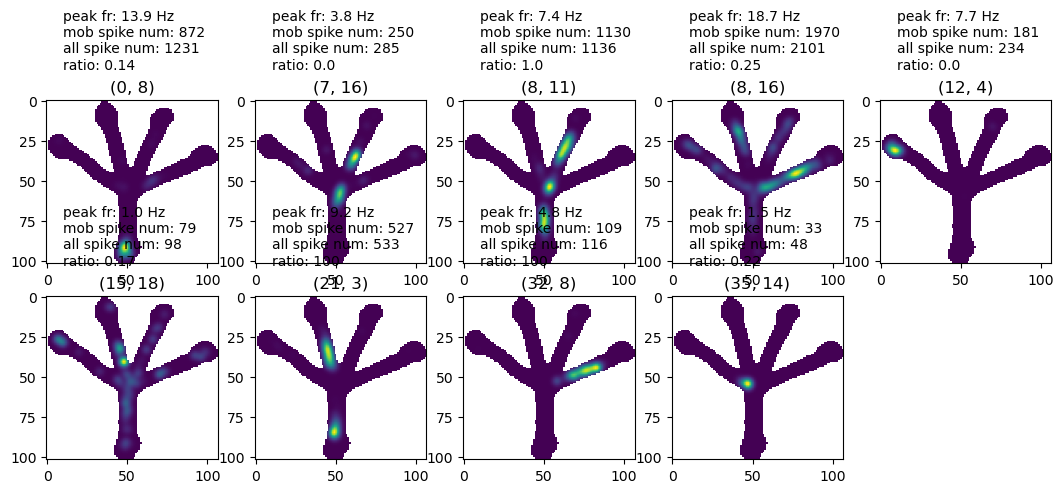

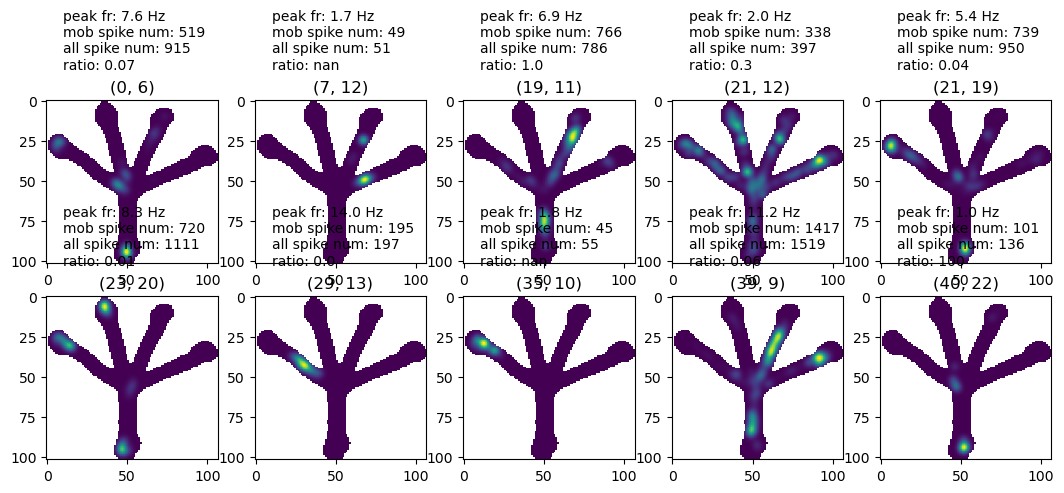

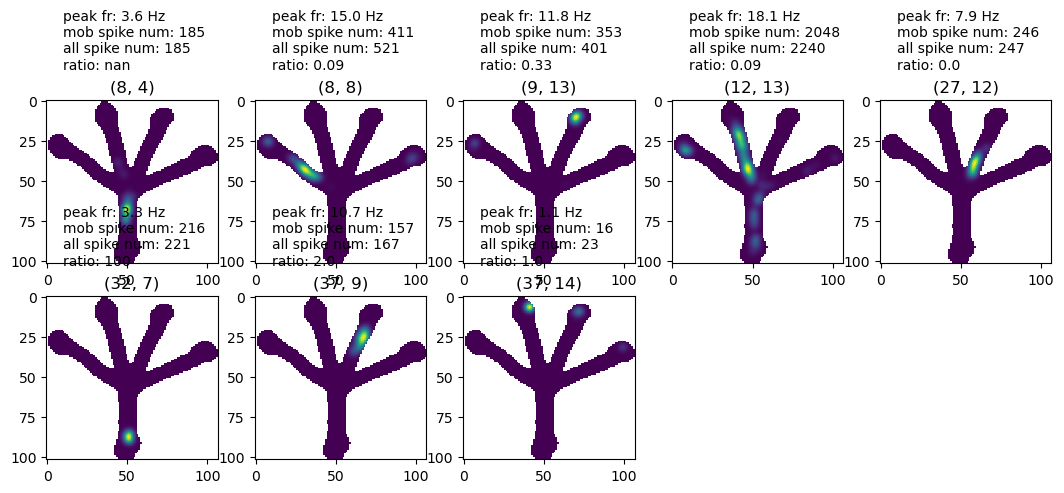

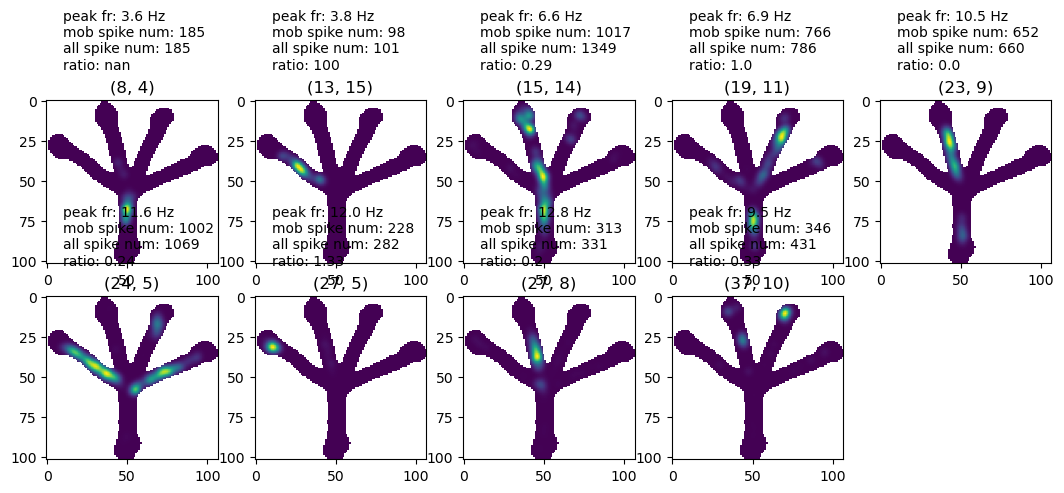

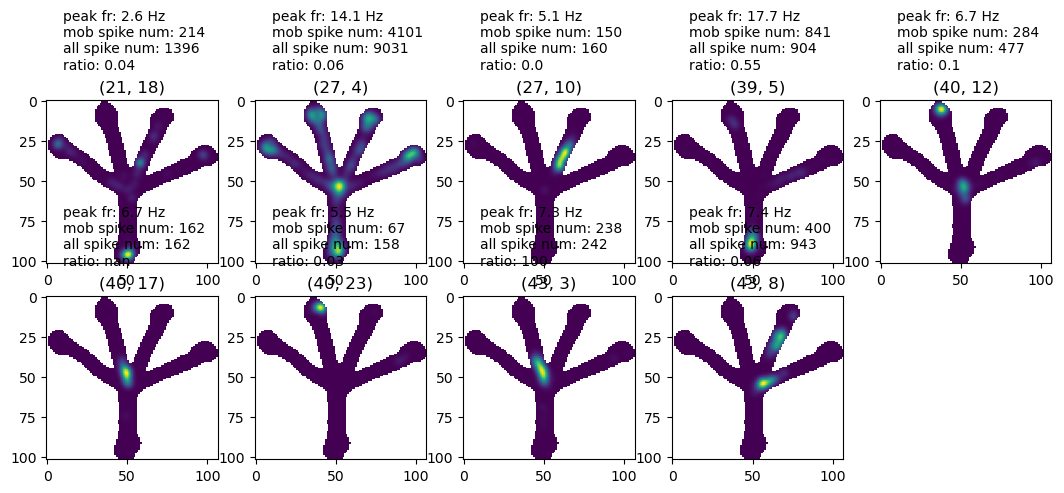

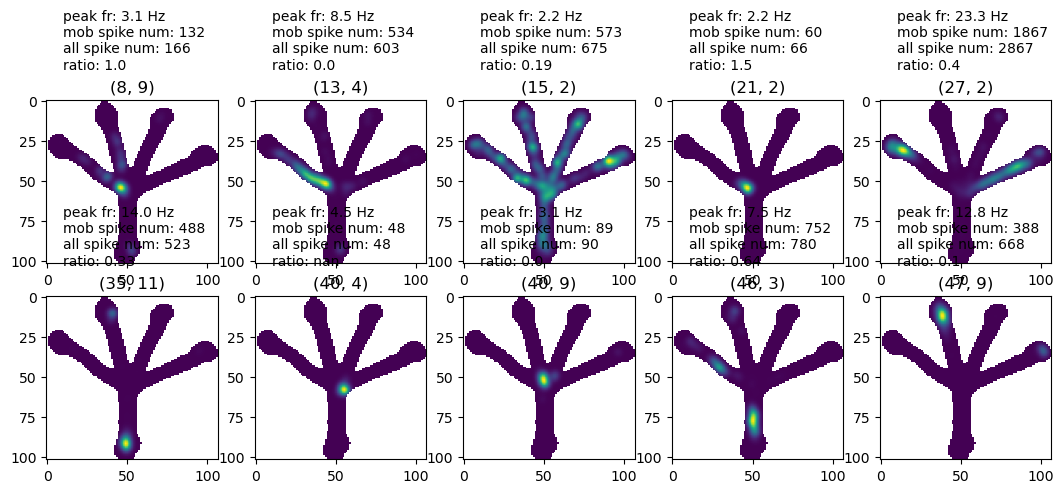

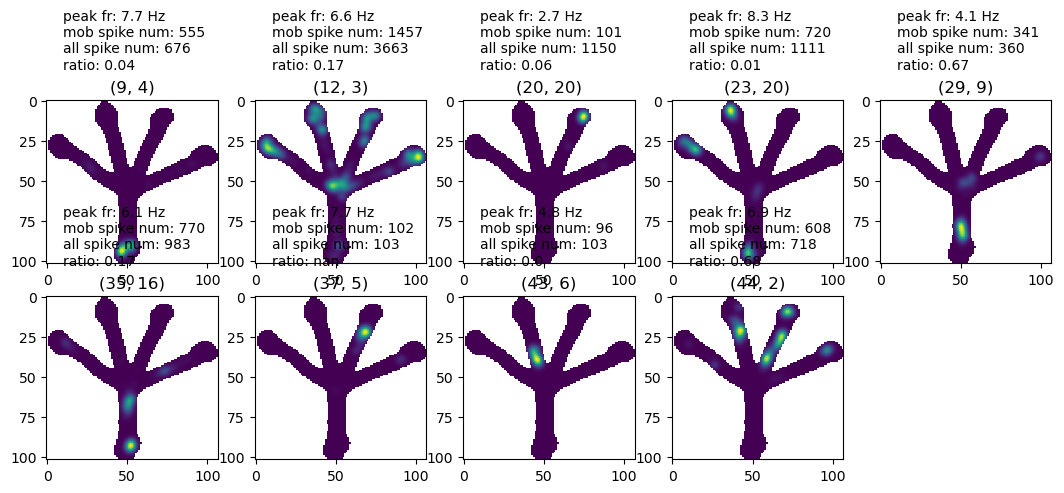

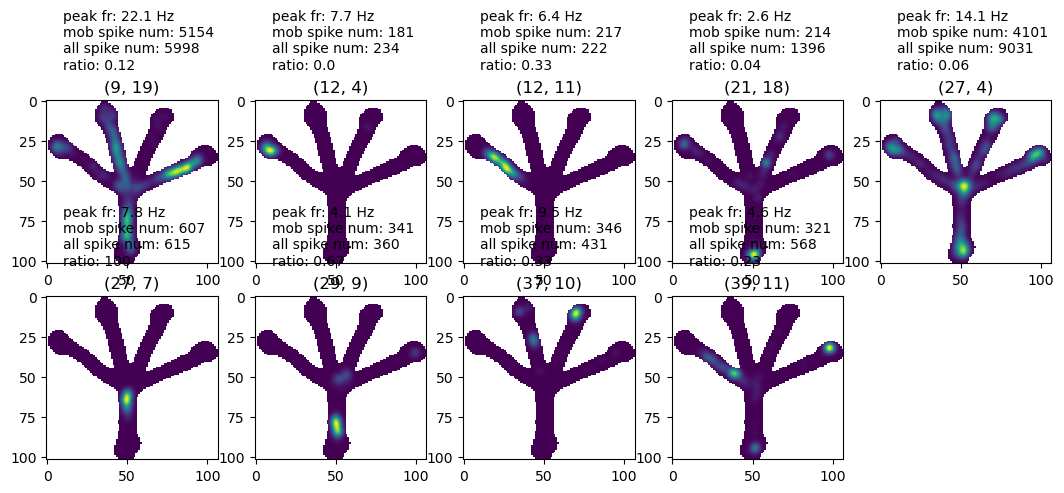

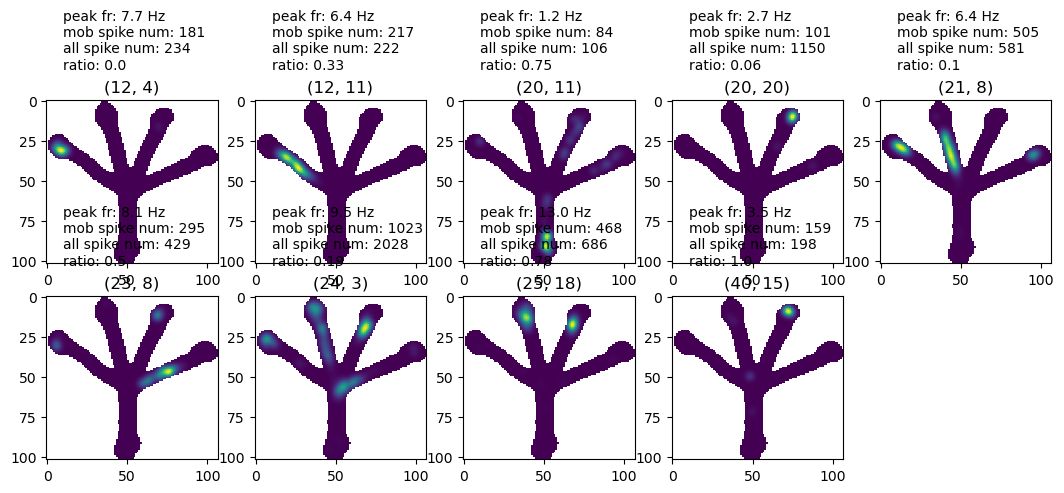

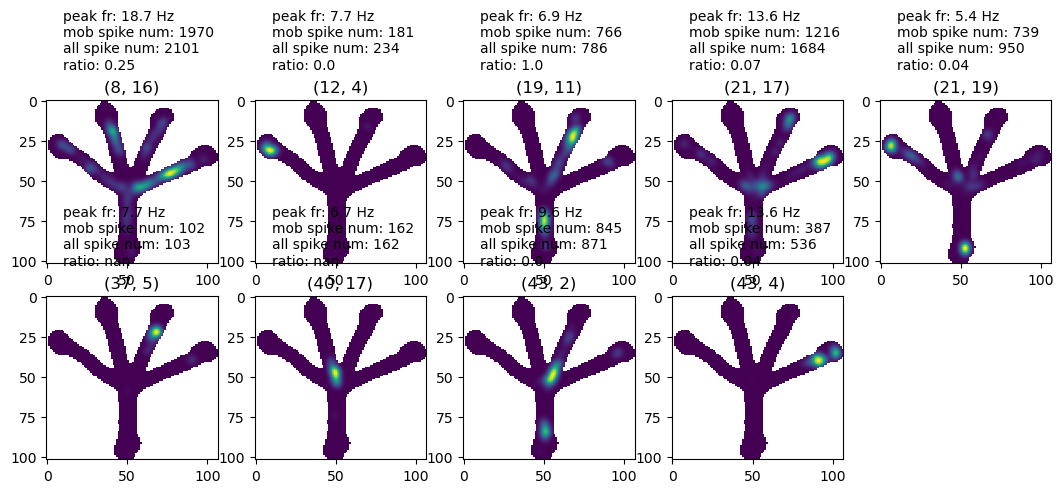

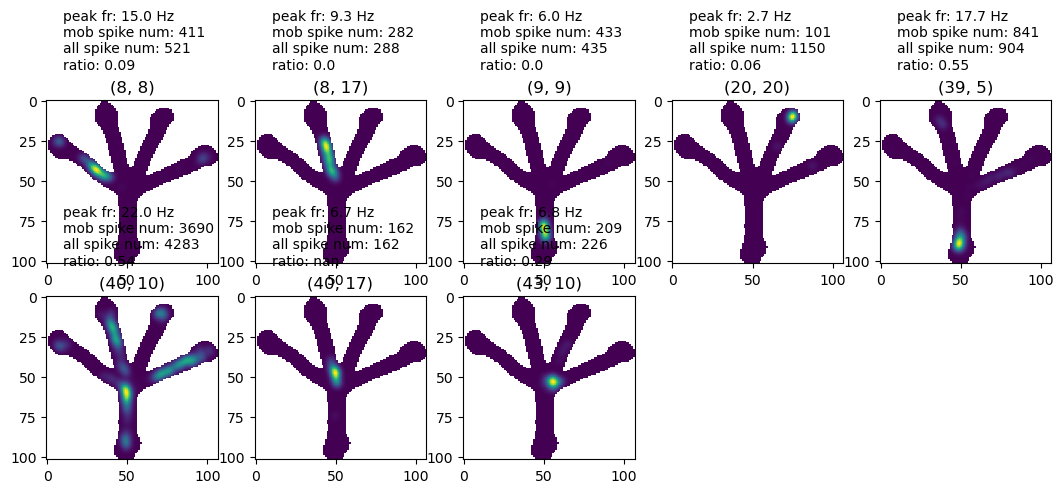

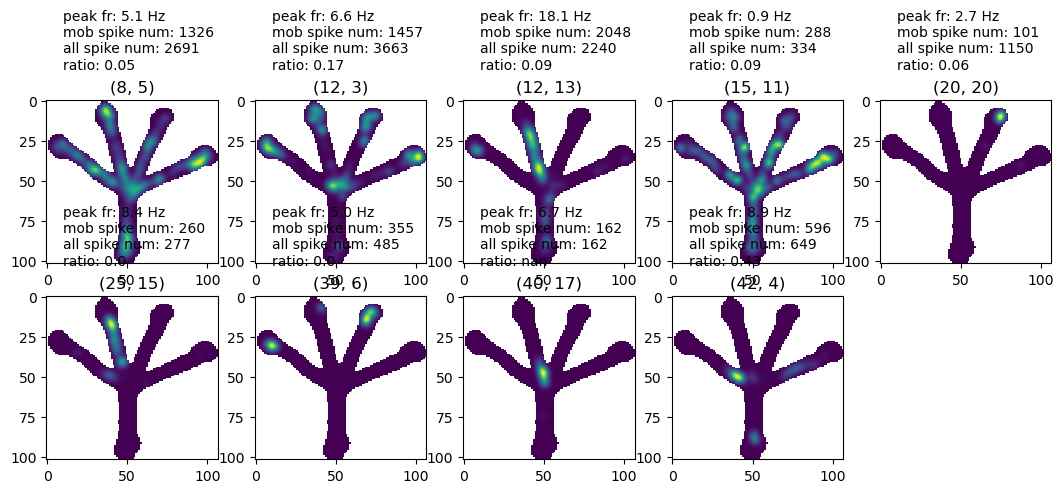

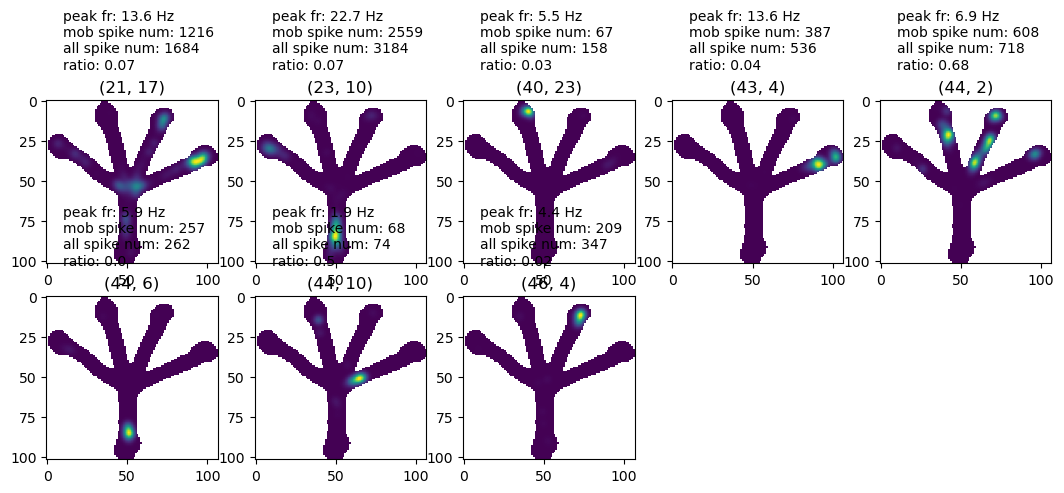

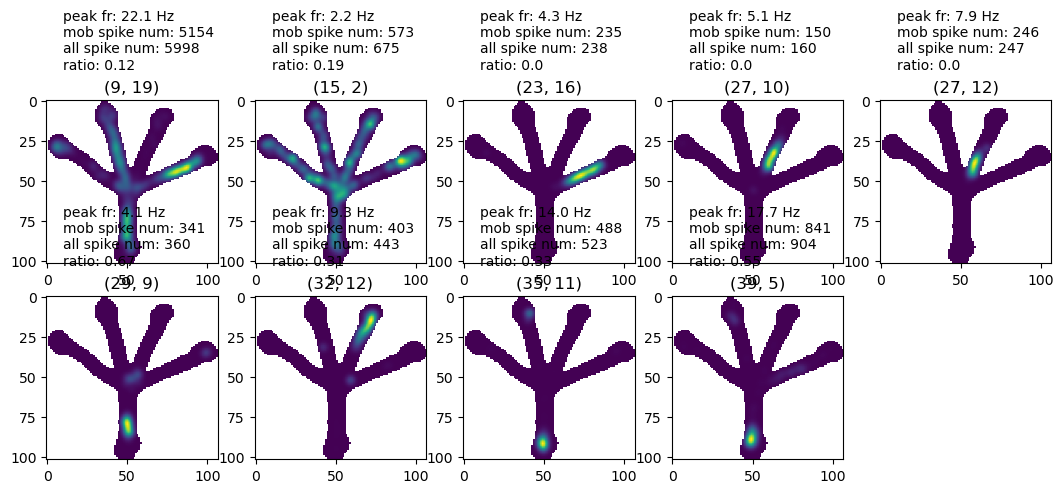

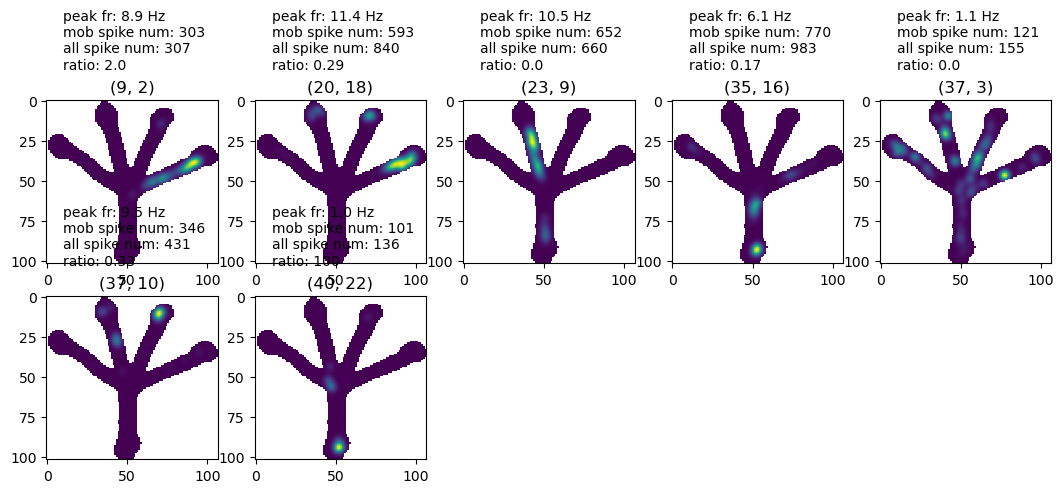

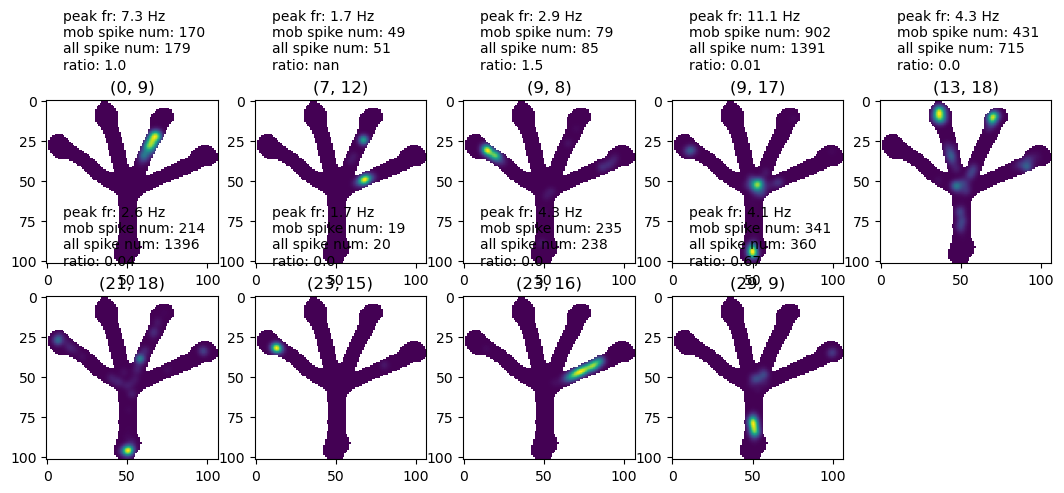

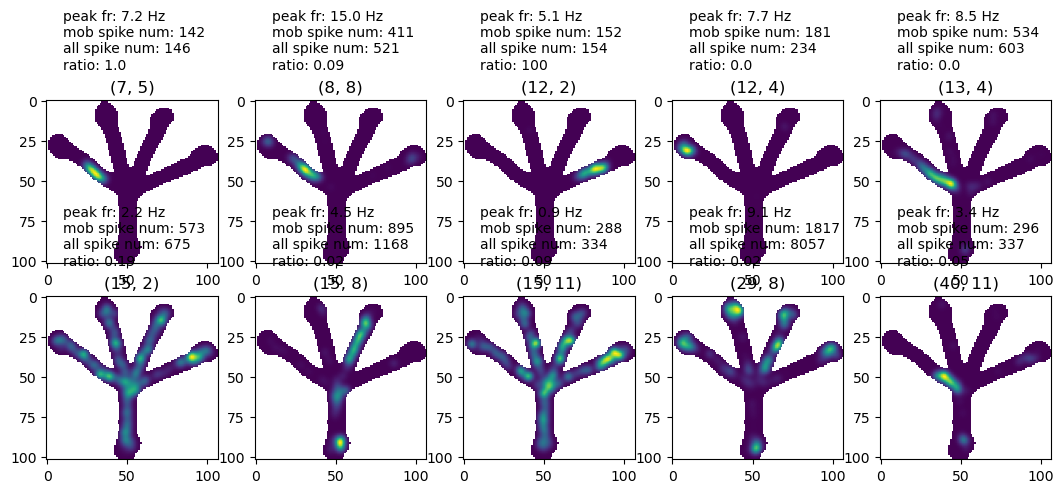

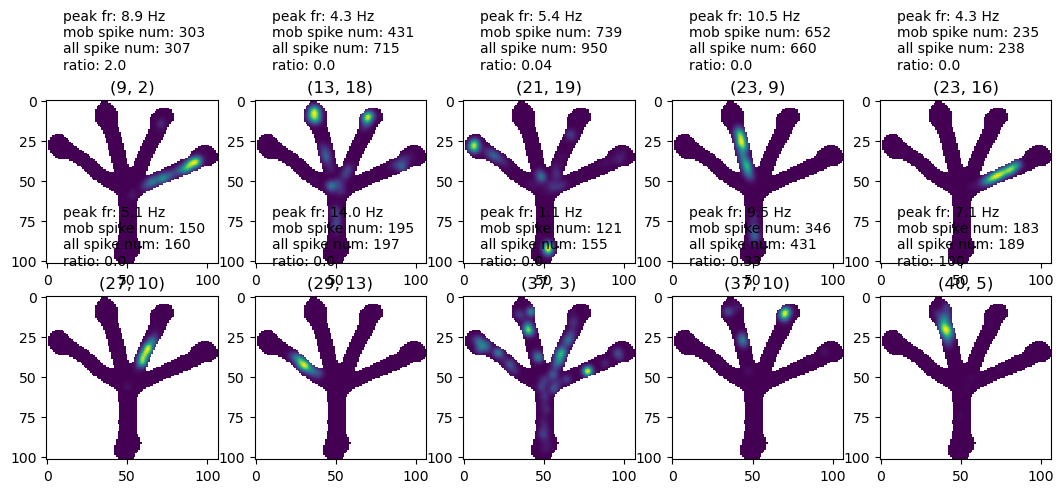

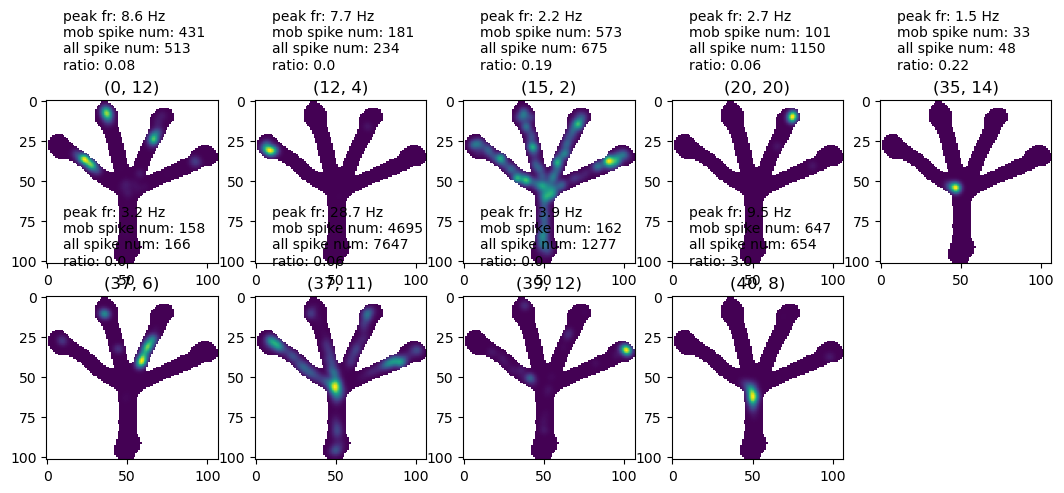

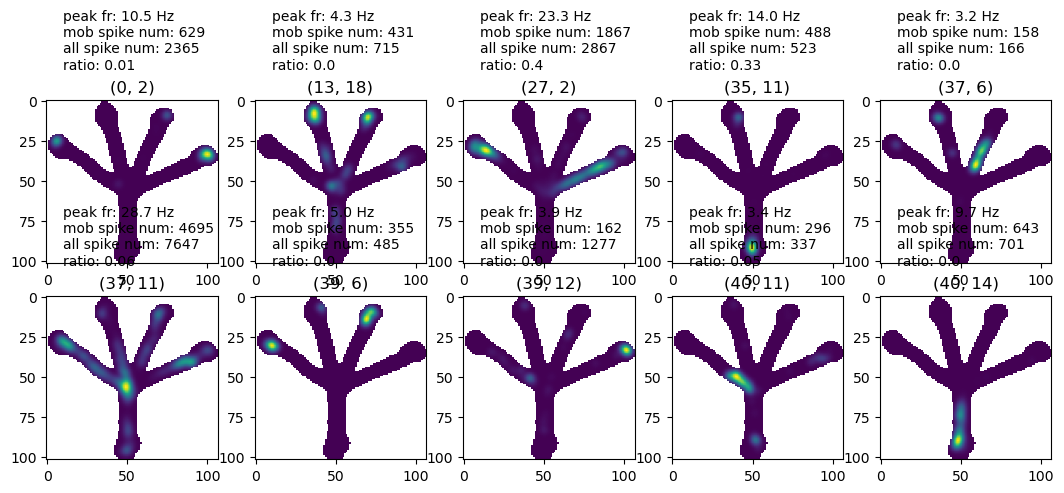

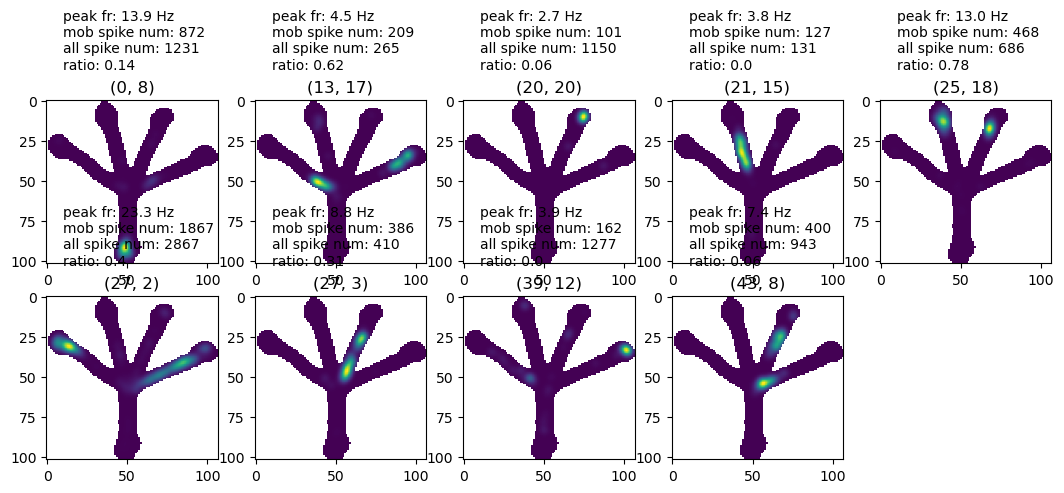

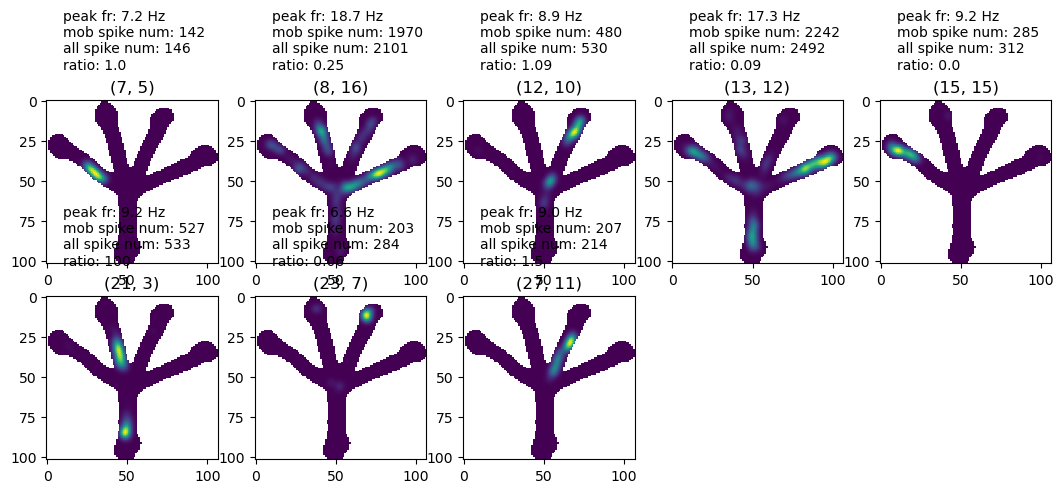

In [228]:
for ic_vector in ic_vectors:
    ic_vector_cell_ind = np.argwhere(ic_vector >= np.quantile(ic_vector, 0.95)).ravel()
    ic_vector_cell_ind = ic_vector_cell_ind[:10]

    cells_to_plot = [unit_name[id] for id in ic_vector_cell_ind]
    
    fig, axes = plt.subplots(2,5, figsize = (13,7 * 2/3), squeeze = True)
    
    ind = 0
    for p in np.arange(len(cells_to_plot)):
        
        (e,u) = cells_to_plot[p]
        if not (e,u) in placefields.keys():
            continue
        axes[np.unravel_index(ind, axes.shape)].imshow(placefields[(e,u)])
        axes[np.unravel_index(ind, axes.shape)].set_title(str((e,u)))
        axes[np.unravel_index(ind, axes.shape)].text(10,-20,"peak fr: "+str(round(peak_frs[(e,u)],1))+" Hz \n" + 
                                                     "mob spike num: "+str(mobility_spike_counts[e,u]) + "\n" +
                                                     "all spike num: "+str(all_spike_counts[e,u]) + "\n" + 
                                                     "ratio: "+ str(np.round(count_ratio_dict[e,u],2)))
        ind = ind + 1
    
    for p in np.arange(ind, 10):
        axes[np.unravel_index(p, axes.shape)].set_axis_off()

In [89]:
unit_name

[(0, 2),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (0, 10),
 (0, 12),
 (3, 2),
 (3, 3),
 (7, 1),
 (7, 5),
 (7, 6),
 (7, 9),
 (7, 11),
 (7, 12),
 (7, 13),
 (7, 15),
 (7, 16),
 (7, 17),
 (8, 4),
 (8, 5),
 (8, 7),
 (8, 8),
 (8, 9),
 (8, 10),
 (8, 11),
 (8, 16),
 (8, 17),
 (9, 2),
 (9, 3),
 (9, 4),
 (9, 5),
 (9, 6),
 (9, 7),
 (9, 8),
 (9, 9),
 (9, 10),
 (9, 12),
 (9, 13),
 (9, 16),
 (9, 17),
 (9, 18),
 (9, 19),
 (12, 2),
 (12, 3),
 (12, 4),
 (12, 5),
 (12, 9),
 (12, 10),
 (12, 11),
 (12, 12),
 (12, 13),
 (12, 14),
 (12, 15),
 (13, 4),
 (13, 5),
 (13, 6),
 (13, 12),
 (13, 13),
 (13, 15),
 (13, 17),
 (13, 18),
 (15, 2),
 (15, 4),
 (15, 5),
 (15, 6),
 (15, 8),
 (15, 9),
 (15, 10),
 (15, 11),
 (15, 14),
 (15, 15),
 (15, 16),
 (15, 18),
 (15, 19),
 (19, 11),
 (19, 16),
 (20, 5),
 (20, 9),
 (20, 10),
 (20, 11),
 (20, 18),
 (20, 19),
 (20, 20),
 (20, 21),
 (20, 22),
 (21, 2),
 (21, 3),
 (21, 5),
 (21, 6),
 (21, 7),
 (21, 8),
 (21, 9),
 (21, 12),
 (21, 14),
 (21, 15),
 (21, 17),
 (21, 18),
 (21, 19),
 

In [233]:
IntervalList_pd=pd.DataFrame(IntervalList & {'nwb_file_name': nwb_copy_file_name})
interval_pd=pd.DataFrame((TaskEpoch & {'nwb_file_name':nwb_copy_file_name}).fetch())
interval_pd.insert(5, "pos_name", '')

# select position timestamps, only maze sessions or sleep are selected
for i in IntervalList_pd.index:
    interval=IntervalList_pd['interval_list_name'][i]
    if interval[0:3]=='pos':
        interval_pd.loc[int(interval[4:6]),'pos_name']=interval

#position_interval=interval_pd.pos_name #use this line if needed
session_interval=[]
position_interval=[]
for i in interval_pd.index:
    if interval_pd.loc[i,"task_name"]=="maze":
        session_interval.append(interval_pd.loc[i,"interval_list_name"])
        position_interval.append(interval_pd.loc[i,"pos_name"])
        
print(session_interval)
print(position_interval)

['02_Seq2Session1', '04_Seq2Session2', '06_Seq2Session3', '08_Seq1Session4', '10_Seq1Session5', '12_Seq1Session6']
['pos 1 valid times', 'pos 3 valid times', 'pos 5 valid times', 'pos 7 valid times', 'pos 9 valid times', 'pos 11 valid times']


## Pick a session

In [234]:
session_ind = 2
session_name = session_interval[session_ind]
pos_name = position_interval[session_ind]
print(session_name)

06_Seq2Session3


### Get Position Info

In [235]:
position_speed = (IntervalPositionInfo & {'nwb_file_name': nwb_copy_file_name,
                  'interval_list_name': pos_name,
                  'position_info_param_name': 'default'}).fetch1_dataframe()

[2023-10-11 22:41:46,883][WARNING]: Skipped checksum for file with hash: 393e030f-3175-936e-23c5-41ac68273e38, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_9I18HQRIQ0.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

In [236]:
position_info = (IntervalLinearizedPosition() &
                 {'nwb_file_name': nwb_copy_file_name,
                  'interval_list_name': pos_name,
                  'position_info_param_name': 'default'}
                ).fetch1_dataframe()
position_info

[2023-10-11 22:41:47,460][WARNING]: Skipped checksum for file with hash: fa2a7c9f-1ae6-ac58-821d-1c8aaa8ede8c, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_SNCQOR3RHE.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

linear_position  track_segment_id  projected_x_position  \
time                                                                    
1.666904e+09         3.413490                 0            210.486888   
1.666904e+09         3.159755                 0            210.469279   
1.666904e+09         3.226442                 0            210.473907   
1.666904e+09         3.604875                 0            210.500169   
1.666904e+09         3.533851                 0            210.495240   
...                       ...               ...                   ...   
1.666905e+09              NaN                 0                   NaN   
1.666905e+09              NaN                 0                   NaN   
1.666905e+09              NaN                 0                   NaN   
1.666905e+09              NaN                 0                   NaN   
1.666905e+09              NaN                 0                   NaN   

              projected_y_position  
time                                
1.666904e+09            230.594740  
1.666904e+09            230.847863  
1.666904e+09            230.781337  
1.666904e+09            230.403816  
1.666904e+09            230.474669  
...                            ...  
1.666905e+09                   NaN  
1.666905e+09                   NaN  
1.666905e+09                   NaN  
1.666905e+09                   NaN  
1.666905e+09                   NaN  

[39608 rows x 4 columns]

### For one session: 
##### 1) remove noise units
##### 2) find spike times for nonnoise units
##### 3) construct nn graph
##### 4) embed with Laplacian

In [237]:
key = {"nwb_file_name": nwb_copy_file_name,
       "sorter":"mountainsort4",
       "sort_interval_name":session_name}

In [238]:
sort_group_ids = (QualityMetrics & key).fetch("sort_group_id")
sort_group_ids

array([ 0,  2,  5, 13, 14, 16, 17, 20, 26, 27, 29, 30, 31])

In [239]:
# decide discretization and duration of data
# use beginning
session_start = position_info.index[np.argwhere(np.array(position_info.track_segment_id>0)).ravel()[0]]
session_end = session_start + 25*60 #spikes.loc[1,"sort_interval"][0][-1][-1]
# use last
#session_end = position_info.index[np.argwhere(np.array(position_info.track_segment_id>0)).ravel()[-1]]-2*60
#session_start = session_end - 22*60 #spikes.loc[1,"sort_interval"][0][-1][-1]

delta_t = 0.2 #200 ms
time_axis = np.arange(session_start,session_end,delta_t) #200 ms bins

In [240]:
# Discretize position info
assert position_speed.shape[0] == position_info.shape[0]
arm=np.zeros_like(time_axis).astype('int');
linearized_location = np.zeros_like(time_axis)+np.nan;
speed = np.zeros_like(time_axis)+np.nan;

for t_ind in range(len(time_axis)):
    t = time_axis[t_ind]
    time_ind = np.argwhere(position_info.index>=t).ravel()[0]
    
    arm[t_ind] = int(position_info.iloc[time_ind]['track_segment_id'])
    speed[t_ind] = position_speed.iloc[time_ind]['head_speed']
    armID=position_info.iloc[time_ind]['linear_position']
    
    if not np.isnan(armID):
        linearized_location[t_ind] = int(armID)
arm[arm==1]=5
arm[arm==6]=1
arm[arm==7]=2
arm[arm==8]=3
arm[arm==9]=4

In [241]:
# Discretize neural data
R = []
for tet in sort_group_ids:
    key["sort_group_id"]=tet
    '''
    load metric
    '''
    metrics_json_path=(QualityMetrics & key).fetch1("quality_metrics_path")
    # Opening JSON file
    with open(metrics_json_path) as json_file:
        metrics_json = json.load(json_file)
    snr = metrics_json['snr']

    nwb_units = (CuratedSpikeSorting() & key).fetch_nwb()[0]["units"]

    accepted_units=[unit_id for unit_id in nwb_units.index if snr[str(unit_id)]>=15] #15
    print('Accepted units: ', accepted_units)
    
    cs=(CuratedSpikeSorting() & key).fetch_nwb()
    spikes = pd.DataFrame(cs[0]['units'])
    
    rate_matrix = np.zeros((len(time_axis)-1,len(accepted_units)))
    for i in range(len(accepted_units)):
        u = accepted_units[i]
        hist, _ = np.histogram(spikes.loc[u,'spike_times'],bins=time_axis,density=False)
        rate_matrix[:,i-1]=hist #-1 because index 1 indexed
    rate_matrix = rate_matrix/delta_t
    R.append(rate_matrix)

'''
fig,axes=plt.subplots(1,1,figsize=(15,5))
plt.imshow(rate_matrix.T,aspect='auto',vmax=3)
'''

[2023-10-11 22:41:56,047][WARNING]: Skipped checksum for file with hash: 30b24308-c33f-ed20-2822-6fd8000628bc, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_8P6MH6LXN6.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [2, 3, 6, 7, 8, 9, 11, 13, 14]


[2023-10-11 22:41:56,563][WARNING]: Skipped checksum for file with hash: 30b24308-c33f-ed20-2822-6fd8000628bc, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_8P6MH6LXN6.nwb
[2023-10-11 22:41:56,995][WARNING]: Skipped checksum for file with hash: 4f48060c-e02e-6361-000f-fcecbb0443af, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_L8S9HE8H9T.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alia

Accepted units:  []


[2023-10-11 22:41:57,498][WARNING]: Skipped checksum for file with hash: 4f48060c-e02e-6361-000f-fcecbb0443af, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_L8S9HE8H9T.nwb
[2023-10-11 22:41:57,933][WARNING]: Skipped checksum for file with hash: 0a1e82c1-94a6-ae1b-0328-fedd91b55994, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_CO1S1YZP2Z.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alia

Accepted units:  [2, 3, 6, 9, 10, 11, 13, 14, 15]


[2023-10-11 22:41:58,462][WARNING]: Skipped checksum for file with hash: 0a1e82c1-94a6-ae1b-0328-fedd91b55994, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_CO1S1YZP2Z.nwb
[2023-10-11 22:41:58,903][WARNING]: Skipped checksum for file with hash: 8232b6d2-067d-b301-96a5-0bab82aee8bd, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_1EFXL33OJT.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alia

Accepted units:  [3, 5, 7, 9, 10, 11]


[2023-10-11 22:41:59,480][WARNING]: Skipped checksum for file with hash: 8232b6d2-067d-b301-96a5-0bab82aee8bd, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_1EFXL33OJT.nwb
[2023-10-11 22:41:59,915][WARNING]: Skipped checksum for file with hash: 6ab41926-7146-6de4-e079-3ee29d9a4b9c, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_MB4USHVD96.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alia

Accepted units:  [4, 7, 9, 10, 18, 19, 20, 21]


[2023-10-11 22:42:00,504][WARNING]: Skipped checksum for file with hash: 6ab41926-7146-6de4-e079-3ee29d9a4b9c, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_MB4USHVD96.nwb
[2023-10-11 22:42:00,956][WARNING]: Skipped checksum for file with hash: 72319583-d21b-3a2e-dba0-11aca398adfe, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_7S87CPWUI6.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alia

Accepted units:  [4, 5, 10, 11, 13]


[2023-10-11 22:42:01,481][WARNING]: Skipped checksum for file with hash: 72319583-d21b-3a2e-dba0-11aca398adfe, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_7S87CPWUI6.nwb
[2023-10-11 22:42:01,960][WARNING]: Skipped checksum for file with hash: eb7fa895-7354-4e33-29ff-eb5e010a0155, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_SYB3URNDNI.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alia

Accepted units:  [5, 6, 7, 11, 12, 13, 14, 16]


[2023-10-11 22:42:02,502][WARNING]: Skipped checksum for file with hash: eb7fa895-7354-4e33-29ff-eb5e010a0155, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_SYB3URNDNI.nwb
[2023-10-11 22:42:02,938][WARNING]: Skipped checksum for file with hash: 49614108-c2b2-3717-5226-99e25a07aa52, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_0AAN6FFYRG.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alia

Accepted units:  [2, 7, 11, 13, 18, 19, 20]


[2023-10-11 22:42:03,556][WARNING]: Skipped checksum for file with hash: 49614108-c2b2-3717-5226-99e25a07aa52, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_0AAN6FFYRG.nwb
[2023-10-11 22:42:04,024][WARNING]: Skipped checksum for file with hash: 80d1659d-d5c3-b313-c963-76a3b47444cf, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_AW45LYZV0E.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alia

Accepted units:  [3, 5, 6, 9, 11]


[2023-10-11 22:42:04,670][WARNING]: Skipped checksum for file with hash: 80d1659d-d5c3-b313-c963-76a3b47444cf, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_AW45LYZV0E.nwb
[2023-10-11 22:42:05,148][WARNING]: Skipped checksum for file with hash: d1f5eb50-de8c-eb34-6a5e-efccf46cd0f0, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_1VYKELVLIS.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alia

Accepted units:  [5]


[2023-10-11 22:42:05,716][WARNING]: Skipped checksum for file with hash: d1f5eb50-de8c-eb34-6a5e-efccf46cd0f0, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_1VYKELVLIS.nwb
[2023-10-11 22:42:06,171][WARNING]: Skipped checksum for file with hash: 0c9eae9d-0b06-5af4-e805-a9dec9d56d6e, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_RJ87G1LQN8.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alia

Accepted units:  [7]


[2023-10-11 22:42:06,777][WARNING]: Skipped checksum for file with hash: 0c9eae9d-0b06-5af4-e805-a9dec9d56d6e, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_RJ87G1LQN8.nwb
[2023-10-11 22:42:07,262][WARNING]: Skipped checksum for file with hash: bab52bfc-9942-d71f-f10c-a30bfcbcecfa, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_VK5QG7BQ1D.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alia

Accepted units:  [6, 7, 8, 11, 12, 13, 15, 17, 19]


[2023-10-11 22:42:07,829][WARNING]: Skipped checksum for file with hash: bab52bfc-9942-d71f-f10c-a30bfcbcecfa, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_VK5QG7BQ1D.nwb
[2023-10-11 22:42:08,290][WARNING]: Skipped checksum for file with hash: 1793d5d1-37ca-2977-03a6-77d0201f861e, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_9TX1AXEHXP.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alia

Accepted units:  [3, 4, 5, 6]


[2023-10-11 22:42:08,941][WARNING]: Skipped checksum for file with hash: 1793d5d1-37ca-2977-03a6-77d0201f861e, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_9TX1AXEHXP.nwb


"\nfig,axes=plt.subplots(1,1,figsize=(15,5))\nplt.imshow(rate_matrix.T,aspect='auto',vmax=3)\n"

In [242]:
R = np.hstack(R);
print(R.shape)

(7499, 72)


In [243]:
arm = arm[:-1]
linearized_location=linearized_location[:-1]
time_axis=time_axis[:-1]
speed=speed[:-1]

In [272]:
arm_only = False
run_only = True

In [273]:
## choose only none center 
if arm_only:
    arm_ind=np.isin(arm,[1,2,3,4])
    R = R[arm_ind,:]
    arm = arm[arm_ind]
    linearized_location=linearized_location[arm_ind]
    time_axis=time_axis[arm_ind]
    
    R=R[:3500,:]
    arm=arm[:3500]
    linearized_location=linearized_location[:3500]
    time_axis=time_axis[:3500]

In [274]:
## choose only none center 
if run_only:
    arm_ind=speed>5
    R = R[arm_ind,:]
    arm = arm[arm_ind]
    linearized_location=linearized_location[arm_ind]
    time_axis=time_axis[arm_ind]
    
    R=R[:4500,:]
    arm=arm[:4500]
    linearized_location=linearized_location[:4500]
    time_axis=time_axis[:4500]

### Spectral Cluster in time direction

In [275]:
'''then use sklearn package'''
from sklearn.manifold import SpectralEmbedding

embedding = SpectralEmbedding(n_components=4,affinity='nearest_neighbors',n_neighbors=50) #n_neighbors=10
X_transformed = embedding.fit_transform(R)
X_transformed.shape

(3671, 4)

In [246]:
N = embedding.affinity_matrix_.toarray()
N_reorders,arm_breaks = reorder_affinity_by_arm(N,arm,linearized_location)

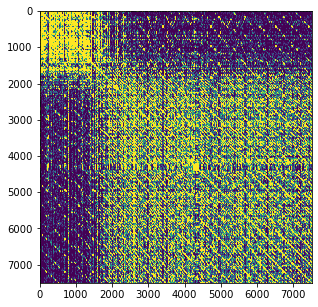

In [247]:
%matplotlib inline
fig,axes=plt.subplots(1,1,figsize=(5,5))
plt.imshow(N,vmax=0.01,interpolation='bilinear', rasterized=False)

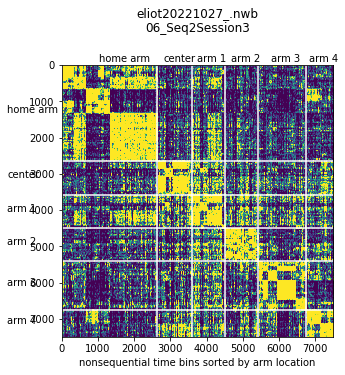

In [248]:
%matplotlib inline
fig,axes=plt.subplots(1,1,figsize=(5,5))
plt.imshow(N_reorders,vmax=0.01,interpolation='bilinear', rasterized=False)
arms_name = ['home arm','center','arm 1','arm 2','arm 3','arm 4']
a_ind=0
for a_ind in range(len(arms_name)):
    b = arm_breaks[a_ind]
    plt.axvline(b,color='w')
    plt.axhline(b,color='w')
    plt.text(-1500,0.5*(b+arm_breaks[a_ind+1]),arms_name[a_ind])
    plt.text(0.5*(b+arm_breaks[a_ind+1])-300,-100,arms_name[a_ind])
axes.set_xlabel('nonsequential time bins sorted by arm location')
figureName=nwb_copy_file_name+'_'+session_name
plt.title(nwb_copy_file_name+'\n'+session_name,y=1.1)
plt.savefig(outputFolder+figureName+'.png', dpi=300,bbox_inches='tight')
plt.savefig(outputFolder+figureName+'.pdf', dpi=300,bbox_inches='tight')

In [276]:
# color code by arms
color_palet[0,:] = [0.5,0.5,0.5]
color_palet[5,:] = [0.6,0.2,0.2]
colors_arm=[]
for t_ind in range(R.shape[0]):
    colors_arm.append(color_palet[arm[t_ind],:])

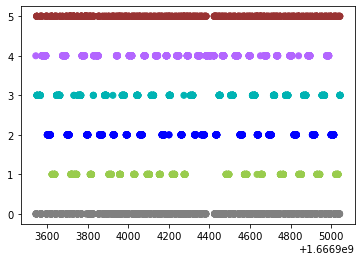

In [277]:
%matplotlib inline
plt.scatter(time_axis,arm,color=colors_arm)

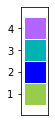

In [199]:
fig,axes=plt.subplots(1,1,figsize=(0.5,2))
for i in range(1,5):
    plt.scatter(1,i,color=color_palet[i,:],s=400,marker='s');
axes.get_xaxis().set_ticks([]);
plt.ylim(0, 5)
axes.get_yaxis().set_ticks([1,2,3,4]);

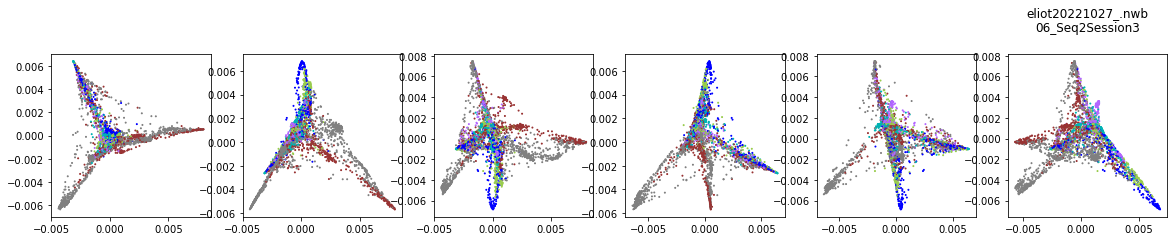

In [278]:
%matplotlib inline

fig,axes=plt.subplots(1,6,figsize=(20,3))

axes[0].scatter(X_transformed[:,0],X_transformed[:,1],color=colors_arm,s=1)
axes[1].scatter(X_transformed[:,0],X_transformed[:,2],color=colors_arm,s=1)
axes[2].scatter(X_transformed[:,0],X_transformed[:,3],color=colors_arm,s=1)
axes[3].scatter(X_transformed[:,1],X_transformed[:,2],color=colors_arm,s=1)
axes[4].scatter(X_transformed[:,1],X_transformed[:,3],color=colors_arm,s=1)
axes[5].scatter(X_transformed[:,2],X_transformed[:,3],color=colors_arm,s=1)

figureName=nwb_copy_file_name+'_'+session_name+'_Laplacian'
plt.title(nwb_copy_file_name+'\n'+session_name,y=1.1)
plt.savefig(outputFolder+figureName+'.png', dpi=300,bbox_inches='tight')
plt.savefig(outputFolder+figureName+'.pdf', dpi=300,bbox_inches='tight')


### Color result by time

In [318]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

colors=[]
for t_ind in range(len(time_axis)-1):
    colors.append(cm.jet(t_ind/len(time_axis)))

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


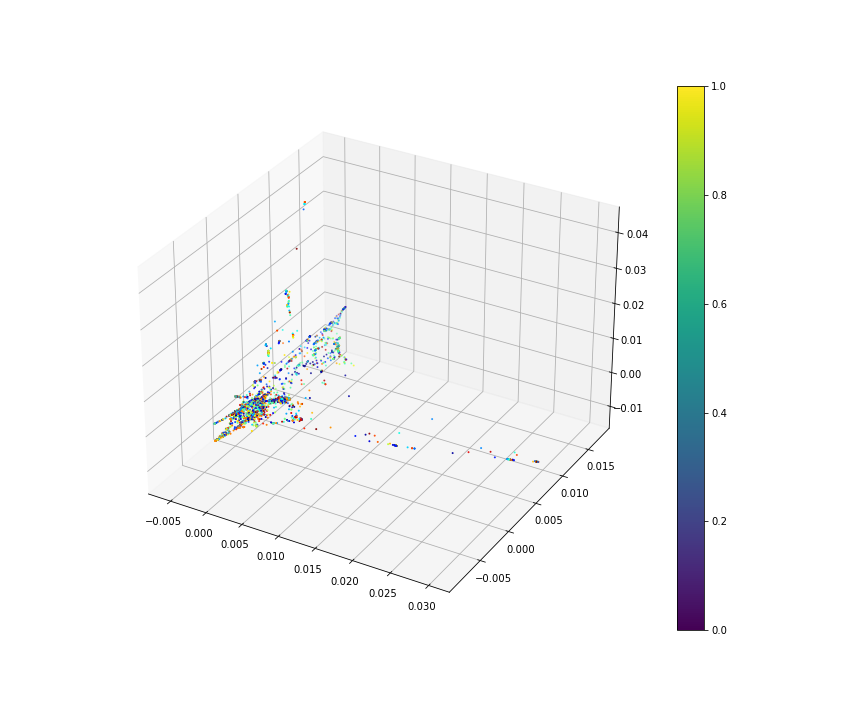

In [319]:
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,10))
ax=plt.subplot(1,1,1,projection='3d')

plot = ax.scatter(X_transformed[:,0],X_transformed[:,1],X_transformed[:,2],color=colors,s=1)
plt.colorbar(plot)

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


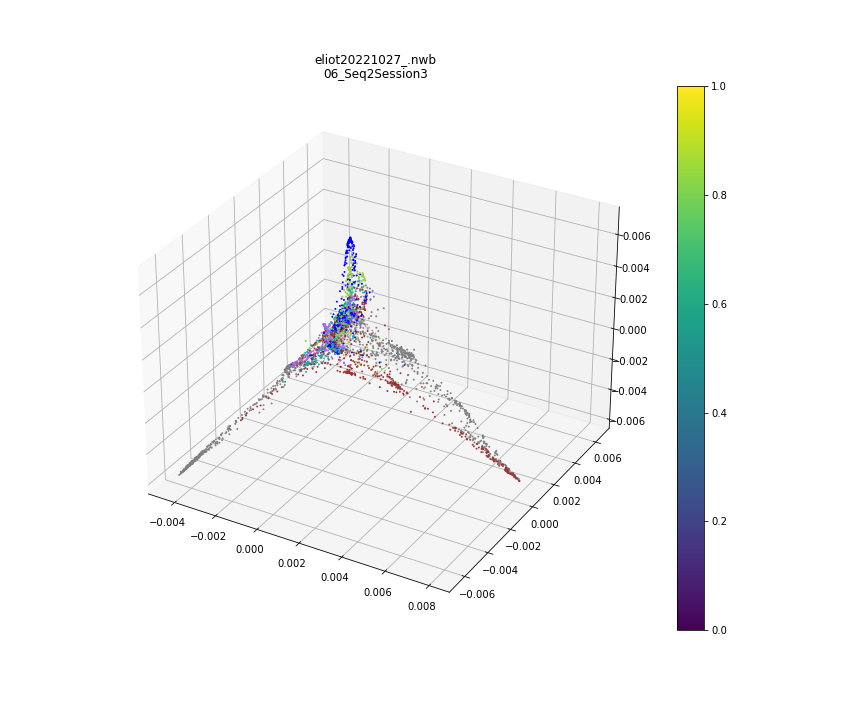

In [279]:
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,10))
ax=plt.subplot(1,1,1,projection='3d')

plot = ax.scatter(X_transformed[:,0],X_transformed[:,1],X_transformed[:,2],color=colors_arm,s=1)
plt.colorbar(plot)

figureName=nwb_copy_file_name+'_'+session_name+'_Laplacian3D'
plt.title(nwb_copy_file_name+'\n'+session_name,y=1.1)
plt.savefig(outputFolder+figureName+'.png', dpi=300,bbox_inches='tight')
plt.savefig(outputFolder+figureName+'.pdf', dpi=300,bbox_inches='tight')

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


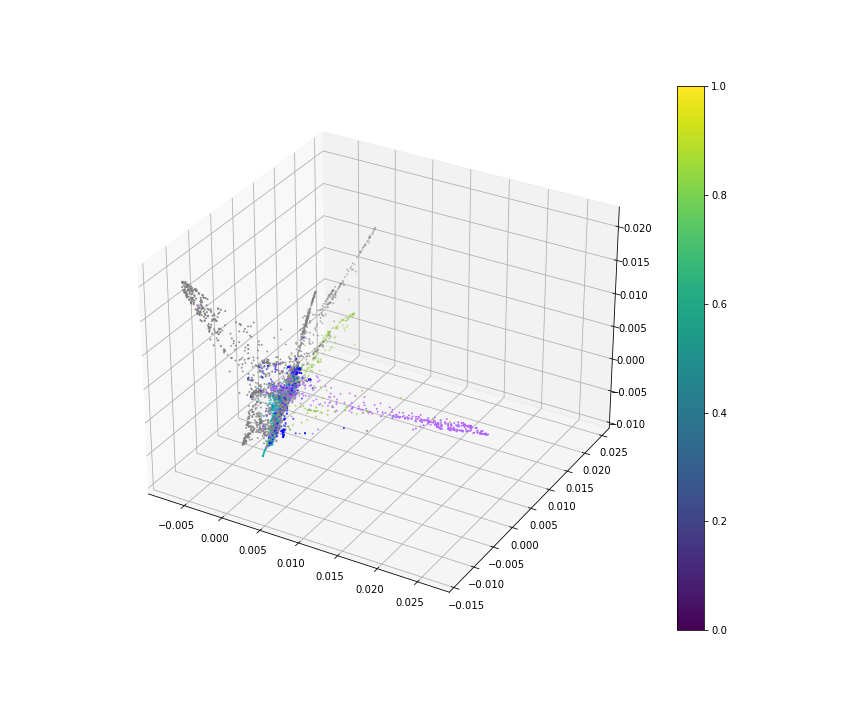

In [596]:
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,10))
ax=plt.subplot(1,1,1,projection='3d')

plot = ax.scatter(X_transformed[:,1],X_transformed[:,2],X_transformed[:,3],color=colors_arm,s=1)
plt.colorbar(plot)

#### (2) Find cell groups

In [409]:
loading = X_transformed.T @ R

In [410]:
C_embedding = SpectralEmbedding(n_components=3,affinity='nearest_neighbors',n_neighbors=10)
C_transformed = C_embedding.fit_transform(loading.T)
C_transformed.shape

(63, 3)

In [411]:
order = []
cell_group = np.argmax(C_transformed.T,axis=0)
for g in range(C_transformed.shape[1]):
    subordering = np.argsort(-C_transformed[cell_group == g,g])
    order.append(np.argwhere(cell_group == g).ravel()[subordering])
cell_ind=np.hstack(order)
block_boundary=np.argwhere(np.diff(cell_group[cell_ind])).ravel()+1

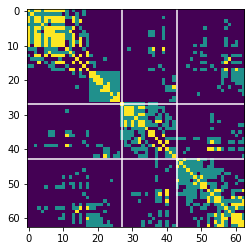

In [412]:
N = C_embedding.affinity_matrix_.toarray() #np.cov(R.T)
plt.imshow(N[cell_ind][:,cell_ind])
for b in block_boundary:
    plt.axvline(b,color='w')
    plt.axhline(b,color='w')

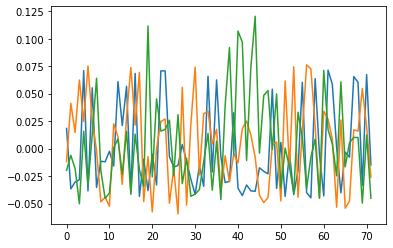

In [152]:
plt.plot(C_transformed)

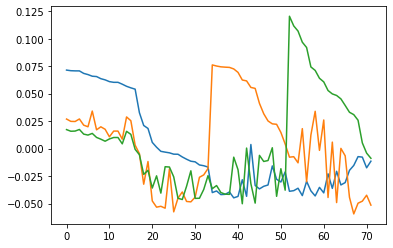

In [153]:
plt.plot(C_transformed[cell_ind,:])

### UMAP

In [280]:
R.shape

(3671, 72)

In [281]:
import umap
reducer = umap.UMAP(n_neighbors=40,min_dist=0.3,n_components=3,metric='cosine') #local_connectivity=15, #40 for early learning
embedding = reducer.fit_transform(R)
embedding.shape

(3671, 3)

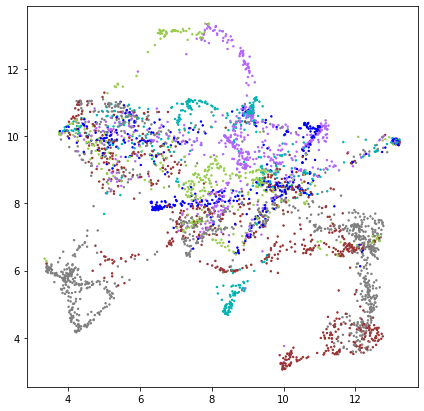

In [282]:
%matplotlib inline

fig,axes=plt.subplots(1,1,figsize=(7,7))

axes.scatter(embedding[:,0],embedding[:,1],color=colors_arm,s=2)

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


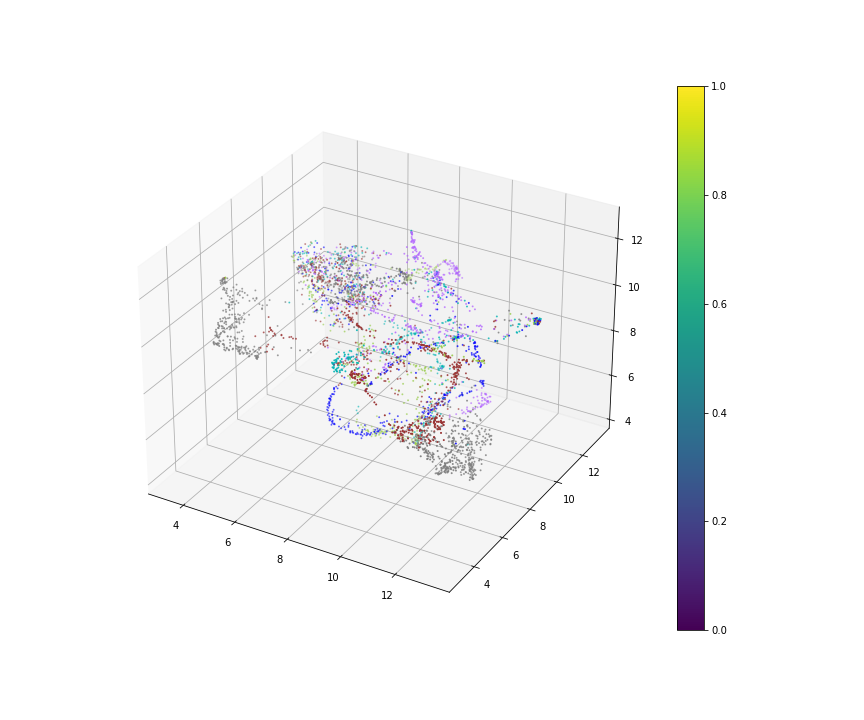

In [283]:
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,10))
ax=plt.subplot(1,1,1,projection='3d')

plot = ax.scatter(embedding[:,0],embedding[:,1],embedding[:,2],color=colors_arm,s=1)
plt.colorbar(plot)

In [284]:
import umap
reducer = umap.UMAP(n_neighbors=50,min_dist=0.25,metric='cosine',output_metric='haversine',n_components=2) #min_dist=0.2 #local_connectivity=15
embedding = reducer.fit_transform(R)
embedding.shape

(3671, 2)

In [285]:
x = np.sin(embedding[:, 0]) * np.cos(embedding[:, 1])
y = np.sin(embedding[:, 0]) * np.sin(embedding[:, 1])
z = np.cos(embedding[:, 0])

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


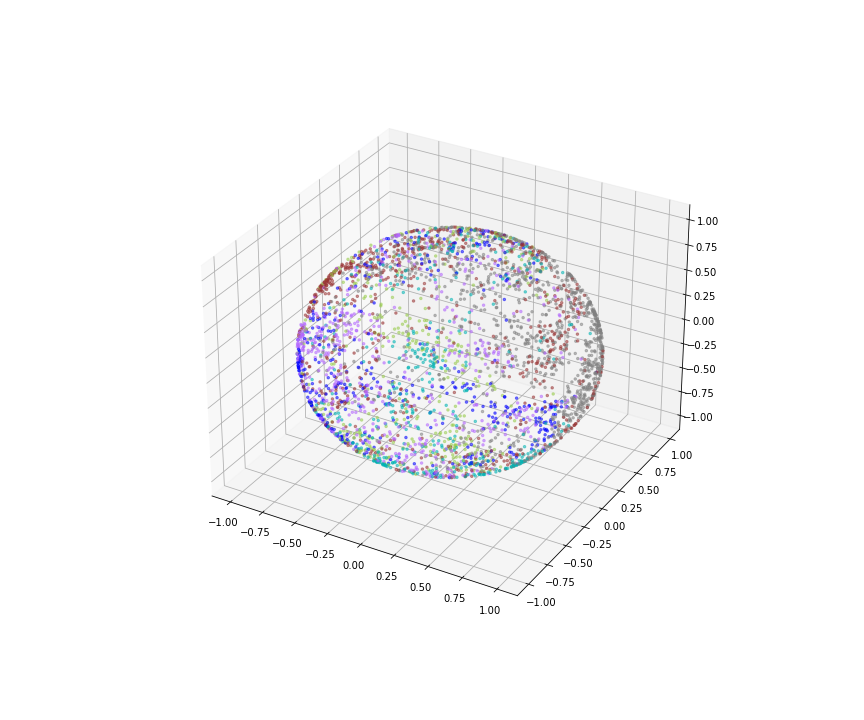

In [286]:
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,10))
ax=plt.subplot(1,1,1,projection='3d')

ax.scatter(x,y,z,color=colors_arm,s=6,alpha=0.5)

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


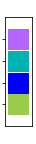

In [603]:
fig,axes=plt.subplots(1,1,figsize=(0.5,2))
for i in range(1,5):
    plt.scatter(1,i,color=color_palet[i,:],s=400,marker='s');
axes.get_xaxis().set_ticks([]);
plt.ylim(0, 5)
axes.get_yaxis().set_ticks([1,2,3,4]);

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,10))
ax=plt.subplot(1,1,1,projection='3d')

plot = ax.scatter(X_transformed[:,0],X_transformed[:,1],X_transformed[:,2],color=colors_arm,s=1)
plt.colorbar(plot)

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


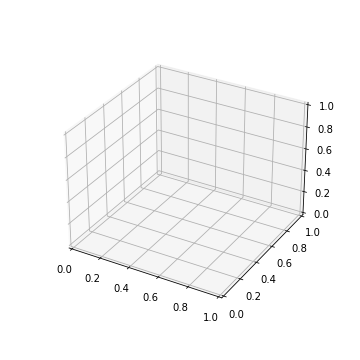

In [50]:
%matplotlib notebook
#widget
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
import time

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')

def animation(i):
    ax.scatter(X_transformed[i,1],X_transformed[i,2],X_transformed[i,3],color='k')
    
ani = FuncAnimation(fig, animation, frames=len(X_transformed[:,1]),interval=20)
plt.show()


## END HERE

### Spectrial Clustering in cell direction

In [440]:
## unused
'''then use sklearn package'''
from sklearn.manifold import SpectralEmbedding

embedding = SpectralEmbedding(n_components=10,affinity='nearest_neighbors',n_neighbors=10)
X_transformed = embedding.fit_transform(R.T)
X_transformed.shape

def pick_high_ind(value):
    # also in the order of descending value
    sort_ind = np.argsort(-value)
    return sort_ind[value[sort_ind]>=np.quantile(value,0.95)]

ind = []
arm_ind=[]
for i in range(10):
    ind.append(pick_high_ind(embedding.embedding_[:,i]))
    arm_ind.append(np.ones(len(pick_high_ind(X_transformed[:,i])))*i)
ind=np.concatenate(ind)
arm_ind=np.concatenate(arm_ind)

_, idx = np.unique(ind, return_index=True)
ind = ind[np.sort(idx)]
arm_ind_ = arm_ind[np.sort(idx)]

arm_breaks=np.argwhere(np.diff(arm_ind_)).ravel()+1
arm_breaks=np.concatenate(([0],arm_breaks))

N=embedding.affinity_matrix_.toarray()
N_=N[ind,:]
N_=N_[:,ind]
%matplotlib inline
fig,axes=plt.subplots(1,1,figsize=(5,5))
plt.imshow(N_)
for b in arm_breaks:
    plt.axvline(b,color='w')
    plt.axhline(b,color='w')

(51, 10)